In [65]:
# Tải dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hoantainson/dataset-weather-vit-nam-trong-1-nm-li")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\phucn\.cache\kagglehub\datasets\hoantainson\dataset-weather-vit-nam-trong-1-nm-li\versions\24


# 1. Libraries

In [66]:
# Thư viện cần dùng
import requests

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# ML cơ bản
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# DL- LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor # <--- Neural Network của Sklearn

# Import 2 thư viện nâng cao
from xgboost import XGBRegressor      
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore") # Lọc warning để có output đẹp

# 2.1. Data Collection

## 1. What subject is your data about?
* **Topic & Domain:** Dữ liệu thời tiết hàng ngày (Daily Weather Data) tại các tỉnh thành của Việt Nam.
* **Real-world context:** Bộ dữ liệu phản ánh điều kiện khí tượng thực tế (nhiệt độ, độ ẩm, lượng mưa, tốc độ gió, chỉ số UV, v.v.) tại 63 tỉnh thành trên khắp Việt Nam. Thông tin này đóng vai trò quan trọng trong việc dự báo thời tiết, lên kế hoạch nông nghiệp, du lịch và các hoạt động đời sống hàng ngày.

## 2. What is the source of your data?
* **Platform:** Kaggle.
* **URL:** [Dataset Weather Viet Nam trong 1 nam lai](https://www.kaggle.com/datasets/hoantainson/dataset-weather-vit-nam-trong-1-nm-li)
* **Author:** Hoàng Thanh Sơn - Sinh viên năm 3 tại Đại học Công nghệ Thông tin (UIT) (Kaggle user: `hoantainson`).
* **Publication Date:** Được cập nhật khoảng 6 tháng trước (dựa trên metadata hiện tại).
* **Collection Date:** Từ `2024-04-21` đến `2025-06-04`.

## 3. Is this data licensed for your use?
* **License:** MIT License.
* **Educational Use Permission:** **Có**. Giấy phép MIT là mã nguồn mở, cho phép sử dụng, sao chép, sửa đổi và phân phối miễn phí, hoàn toàn phù hợp cho mục đích giáo dục và nghiên cứu.

> **MIT License Detail:**
>
> Copyright (c) 2013 Mark Otto.  
> Copyright (c) 2017 Andrew Fong.
>
> Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software...
>
> *THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND...*

## 4. How was this data collected?
* **Collection Method:** Gọi API từ [weatherapi.com](https://www.weatherapi.com/) – nguồn dữ liệu thời tiết lịch sử và dự báo uy tín.
* **Quy trình xử lý:**
    1.  **Retrieval:** Dùng API truy xuất dữ liệu thô (nhiệt độ, lượng mưa...) cho từng tỉnh.
    2.  **Exploratory Data Analysis (EDA):** Kiểm tra cấu trúc, tìm mẫu hình (patterns) và phát hiện điểm bất thường/giá trị thiếu.
    3.  **Data Cleaning:** Xử lý sự không nhất quán để đảm bảo độ chính xác.
    4.  **Compilation:** Tổng hợp dữ liệu sạch thành định dạng `.csv`.
* **Target Population:** 63 tỉnh/thành phố tại Việt Nam.
* **Time Period:** 410 ngày (Từ `2024-04-21` đến `2025-06-04`).
* **Limitations:** Do tổng hợp từ bên thứ ba (API), có thể tồn tại sai số đo đạc từ trạm gốc hoặc giá trị bị thiếu (missing values) khi request.

## 5. Why did you choose this dataset?
* **Interest (Lý do chọn đề tài):**
    * Tính cấp thiết: Việt Nam đang đối mặt với thời tiết cực đoan (bão, lũ) gây thiệt hại lớn về người và tài sản.
    * Mục tiêu: Phân tích dữ liệu 63 tỉnh thành giúp hiểu quy luật khí tượng, hỗ trợ cảnh báo sớm và giảm nhẹ thiên tai.
* **Potential Insights:** Bộ dữ liệu đủ phức tạp để thực hiện các mô hình Machine Learning:
    * **Regression:** Dự báo **nhiệt độ** và **lượng mưa** dựa trên dữ liệu lịch sử.
        * **Input**: Thông tin 1 ngày (gió, nhiệt độ,...)
        * **Output**: Lượng mưa/Nhiệt độ

In [67]:
csv_file = os.path.join(path, "df_weather.csv")

# Đọc dữ liệu
df = pd.read_csv(csv_file)
df.head(5)

,location.name,location.region,location.terrain,location.country,location.lat,location.lon,date,date_epoch,day.maxtemp_c,day.maxtemp_f,...,day.condition.text,day.condition.icon,day.condition.code,day.uv,astro.sunrise,astro.sunset,astro.moonrise,astro.moonset,astro.moon_phase,astro.moon_illumination
0,An Giang,Đồng Bằng Sông Cửu Long,đồng bằng,Vietnam,10.7000,105.1167,2024-04-21,1713657600,38.6,101.5,...,Sunny,//cdn.weatherapi.com/weather/64x64/day/113.png,1000,9.0,05:46 AM,06:11 PM,04:13 PM,03:55 AM,Waxing Gibbous,90
1,Bà Rịa-Vũng Tàu,Đông Nam Bộ,ven biển,Vietnam,10.3500,107.0667,2024-04-21,1713657600,30.2,86.3,...,Moderate rain at times,//cdn.weatherapi.com/weather/64x64/day/299.png,1186,7.0,05:38 AM,06:03 PM,04:05 PM,03:47 AM,Waxing Gibbous,90
2,Bắc Giang,Trung du và miền núi Bắc Bộ,miền núi,Vietnam,21.2667,106.2000,2024-04-21,1713657600,31.9,89.4,...,Heavy rain at times,//cdn.weatherapi.com/weather/64x64/day/305.png,1192,7.0,05:32 AM,06:16 PM,04:09 PM,03:53 AM,Waxing Gibbous,90
3,Bắc Kạn,Trung du và miền núi Bắc Bộ,miền núi,Vietnam,22.1333,105.8333,2024-04-21,1713657600,28.0,82.5,...,Moderate or heavy rain shower,//cdn.weatherapi.com/weather/64x64/day/356.png,1243,6.0,05:32 AM,06:19 PM,04:10 PM,03:54 AM,Waxing Gibbous,90
4,Bạc Liêu,Đồng Bằng Sông Cửu Long,ven biển,Vietnam,9.2850,105.7244,2024-04-21,1713657600,36.1,97.1,...,Partly cloudy,//cdn.weatherapi.com/weather/64x64/day/116.png,1003,9.0,05:45 AM,06:07 PM,04:11 PM,03:52 AM,Waxing Gibbous,90


# 2.2. Data Exploration

In [68]:
print("Dataset Overview")
print("Basic Information:")

num_rows = len(df)
num_cols = len(df.columns)

memory_usage_bytes = df.memory_usage(deep=True).sum()
memory_usage_mb = memory_usage_bytes / (1024 * 1024)

print(f"The dataset has {num_rows:,} rows.")
print(f"The dataset has {num_cols} columns.")
print(f"Each row represents the daily weather summary for a specific location.")
print(f"The overall size of the dataset is {memory_usage_mb:.2f} MB.")

print("\nData Integrity: ")

# 1. Check for duplicates
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"Yes, there are {duplicate_count} duplicated rows.")
else:
    print("No, there are no duplicated rows.")

# 2. Check for empty rows
empty_rows_count = df.isnull().all(axis=1).sum()

if empty_rows_count > 0:
    print(f"No, there are {empty_rows_count} entirely empty rows.")
else:
    print("Yes, all rows are complete (no entirely empty rows).")

# Remove duplicates
if duplicate_count > 0:
    print(f"\nRemoving {duplicate_count} duplicated rows...")
    df = df.drop_duplicates()
    print(f"Duplicates removed")


Dataset Overview
Basic Information:
The dataset has 26,018 rows.
The dataset has 34 columns.
Each row represents the daily weather summary for a specific location.
The overall size of the dataset is 28.73 MB.

Data Integrity: 
Yes, there are 252 duplicated rows.
Yes, all rows are complete (no entirely empty rows).

Removing 252 duplicated rows...
Duplicates removed


**Decision: Duplicates should be removed**

**Justification:**

1. **Data Accuracy**: In this weather dataset, each row corresponds to the specific weather conditions of a unique location on a unique date. Having duplicates implies redundant or erroneous data collection.

2. **Statistical Validity**: Keeping duplicates would artificially inflate the sample size, leading to biased statistical metrics.

3. **Model Performance**: If used for machine learning, duplicates can cause data leakage.

## 2.2. Data Exploration - Column Inventory

**1. What is the meaning/definition of each column?**

Dựa trên thông tin của bộ dữ liệu, dưới đây là định nghĩa chi tiết cho từng cột:

| **Nhóm** | **Tên Cột** | **Định nghĩa** |
| :--- | :--- | :--- |
| **Thông tin Địa điểm** | `location.name` | Tên thành phố/tỉnh (ví dụ: An Giang, Hà Nội). |
| | `location.region` | Vùng miền hành chính (ví dụ: Đồng Bằng Sông Cửu Long). |
| | `location.terrain` | Loại địa hình của địa điểm (ví dụ: đồng bằng, ven biển, miền núi). |
| | `location.country` | Tên quốc gia (Vietnam). |
| | `location.lat` | Tọa độ Vĩ độ của địa điểm. |
| | `location.lon` | Tọa độ Kinh độ của địa điểm. |
| **Thông tin Thời gian** | `date` | Ngày quan sát (định dạng YYYY-MM-DD). |
| | `date_epoch` | Ngày quan sát dưới định dạng Unix epoch. |
| **Nhiệt độ** | `day.maxtemp_c` | Nhiệt độ cao nhất trong ngày (độ C). |
| | `day.maxtemp_f` | Nhiệt độ cao nhất trong ngày (độ F). |
| | `day.mintemp_c` | Nhiệt độ thấp nhất trong ngày (độ C). |
| | `day.mintemp_f` | Nhiệt độ thấp nhất trong ngày (độ F). |
| | `day.avgtemp_c` | Nhiệt độ trung bình trong ngày (độ C). |
| | `day.avgtemp_f` | Nhiệt độ trung bình trong ngày (độ F). |
| **Gió & Lượng mưa** | `day.maxwind_kph` | Tốc độ gió tối đa tính bằng km/h. |
| | `day.maxwind_mph` | Tốc độ gió tối đa tính bằng dặm/h (mph). |
| | `day.totalprecip_mm` | Tổng lượng mưa tính bằng milimet (mm). |
| | `day.totalprecip_in` | Tổng lượng mưa tính bằng inch. |
| | `day.totalsnow_cm` | Tổng lượng tuyết rơi tính bằng centimet (cm). |
| **Tầm nhìn & Độ ẩm** | `day.avgvis_km` | Tầm nhìn xa trung bình tính bằng km. |
| | `day.avgvis_miles` | Tầm nhìn xa trung bình tính bằng dặm (miles). |
| | `day.avghumidity` | Độ ẩm trung bình (%). |
| **Điều kiện Thời tiết** | `day.condition.text` | Mô tả thời tiết bằng văn bản (ví dụ: Nắng, Có thể có mưa rải rác). |
| | `day.condition.icon` | Đường dẫn (URL) đến hình ảnh biểu tượng thời tiết. |
| | `day.condition.code` | Mã định danh duy nhất đại diện cho điều kiện thời tiết. |
| | `day.daily_will_it_rain` | Giá trị Boolean chỉ báo sẽ có mưa hay không (1 = Có, 0 = Không). |
| | `day.daily_chance_of_rain` | Xác suất/Khả năng có mưa tính theo phần trăm (%). |
| | `day.uv` | Chỉ số tia cực tím (UV Index) hàng ngày. |
| **Dữ liệu Thiên văn** | `astro.sunrise` | Thời gian mặt trời mọc. |
| | `astro.sunset` | Thời gian mặt trời lặn. |
| | `astro.moonrise` | Thời gian trăng mọc. |
| | `astro.moonset` | Thời gian trăng lặn. |
| | `astro.moon_phase` | Chu kỳ (pha) của mặt trăng (ví dụ: Trăng khuyết đầu tháng). |
| | `astro.moon_illumination` | Tỷ lệ phần trăm độ sáng của mặt trăng. |


**2. Which columns are relevant to potential analysis?**

Các cột sau đây đã được lựa chọn cho quá trình phân tích:

## Thông tin Địa lý
- `location.name`
- `location.region`
- `location.terrain`
- `location.lat`
- `location.lon`

## Thông tin Thời gian
- `date`

## Nhiệt độ
- `day.maxtemp_c`
- `day.mintemp_c`
- `day.avgtemp_c`

## Gió & Mưa
- `day.maxwind_kph`
- `day.totalprecip_mm`

## Tầm nhìn & Độ ẩm
- `day.avgvis_km`
- `day.avghumidity`

## Điều kiện thời tiết
- `day.daily_will_it_rain`
- `day.daily_chance_of_rain`
- `day.condition.text`
- `day.condition.code`
- `day.uv`

## Dữ liệu Thiên văn
- `astro.sunrise`
- `astro.sunset`


**3. Are there any columns that should be dropped? Why?**

Nhóm quyết định **loại bỏ các cột sau** để đảm bảo chất lượng dữ liệu, loại bỏ sự dư thừa và tập trung vào bối cảnh khí hậu Việt Nam:

* **Đơn vị đo lường dư thừa (Không phải hệ mét):**
    * `day.maxtemp_f`, `day.mintemp_f`, `day.avgtemp_f`: Việt Nam sử dụng thang đo Celsius; độ Fahrenheit là dư thừa.
    * `day.maxwind_mph`, `day.totalprecip_in`, `day.avgvis_miles`: Việt Nam sử dụng hệ mét (km/h, mm, km); các đơn vị đo lường Anh/Mỹ là không cần thiết.

* **Ngữ cảnh không phù hợp (Tuyết):**
    * `day.totalsnow_cm`: Việt Nam là quốc gia nhiệt đới. Tuyết cực kỳ hiếm gặp và không có ý nghĩa thống kê trong bộ dữ liệu này, khiến các cột này trở nên vô nghĩa.

* **Cột chỉ có một giá trị duy nhất:**
    * `location.country`: Toàn bộ dữ liệu chỉ giới hạn trong phạm vi "Vietnam", do đó cột này không có sự biến thiên để phân tích.

* **Metadata dư thừa hoặc mang tính kỹ thuật:**
    * `date_epoch`: Dư thừa vì chúng ta đã có cột `date` ở định dạng con người có thể đọc được.
    * `day.condition.icon`: Cột này chứa đường dẫn ảnh, không hữu ích cho việc phân tích thống kê hay mô hình hóa.

* **Độ liên quan thấp (Dữ liệu Thiên văn):**
    * `astro.moonrise`, `astro.moonset`, `astro.moon_phase`, `astro.moon_illumination`: Mặc dù có sẵn, nhưng chu kỳ mặt trăng có tác động trực tiếp không đáng kể đến việc dự báo thời tiết hàng ngày so với các yếu tố mặt trời và khí quyển. Các cột này được loại bỏ để giảm số chiều dữ liệu.

In [69]:
# Danh sách các cột cần xóa (dựa trên phân tích ở trên)
columns_to_drop = [
    "location.country",         # Tất cả đều là Vietnam
    "date_epoch",               # Dư thừa
    "day.maxtemp_f",            # Dư thừa (Fahrenheit)
    "day.mintemp_f",            # Dư thừa (Fahrenheit)
    "day.avgtemp_f",            # Dư thừa (Fahrenheit)
    "day.maxwind_mph",          # Dư thừa (mph)
    "day.totalprecip_in",       # Dư thừa (inches)
    "day.totalsnow_cm",         # Không liên quan VN
    "day.avgvis_miles",         # Dư thừa (miles)
    "day.condition.icon",       # Metadata không cần thiết
    "astro.moonrise",           # Ít dùng
    "astro.moonset",            # Ít dùng
    "astro.moon_phase",         # Ít dùng
    "astro.moon_illumination",  # Ít dùng
]

# Thực hiện xóa cột
# errors='ignore' giúp tránh lỗi nếu cột không tồn tại trong dataframe
df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

print("Đã xóa các cột không cần thiết.")
print(f"Số lượng cột còn lại: {len(df.columns)}")
print("\nDanh sách cột hiện tại:")
print(df.columns.tolist())

Đã xóa các cột không cần thiết.
Số lượng cột còn lại: 20

Danh sách cột hiện tại:
['location.name', 'location.region', 'location.terrain', 'location.lat', 'location.lon', 'date', 'day.maxtemp_c', 'day.mintemp_c', 'day.avgtemp_c', 'day.maxwind_kph', 'day.totalprecip_mm', 'day.avgvis_km', 'day.avghumidity', 'day.daily_will_it_rain', 'day.daily_chance_of_rain', 'day.condition.text', 'day.condition.code', 'day.uv', 'astro.sunrise', 'astro.sunset']


In [70]:
print("\nData Types:")
print("The current data type of each column: ")
print(df.dtypes)

# 1. Chuyển date sang datetime64
df['date'] = pd.to_datetime(df['date'])
print("Converted 'date' from object to datetime64")

# 2. Chuyển location.name sang category
df['location.name'] = df['location.name'].astype('category')
print("Converted 'location.name' from object to category")

# 3. Chuyển location.region sang category
df['location.region'] = df['location.region'].astype('category')
print("Converted 'location.region' from object to category")

# 4. Chuyển location.terrain sang category
df['location.terrain'] = df['location.terrain'].astype('category')
print("Converted 'location.terrain' from object to category")

# 5. Chuyển day.condition.text sang category
df['day.condition.text'] = df['day.condition.text'].astype('category')
print("Converted 'day.condition.text' from object to category")

# 6. Chuyển day.daily_will_it_rain sang boolean
df['day.daily_will_it_rain'] = df['day.daily_will_it_rain'].astype('bool')
print("Converted 'day.daily_will_it_rain' from int64 to bool")

df['astro.sunrise'] = pd.to_datetime(
    df['date'].astype(str) + ' ' + df['astro.sunrise'],
    format='%Y-%m-%d %I:%M %p',
    errors='coerce'
)
print("Converted 'astro.sunrise' to datetime64")

df['astro.sunset'] = pd.to_datetime(
    df['date'].astype(str) + ' ' + df['astro.sunset'],
    format='%Y-%m-%d %I:%M %p',
    errors='coerce'
)
print("Converted 'astro.sunset' to datetime64")




Data Types:
The current data type of each column: 
location.name                object
location.region              object
location.terrain             object
location.lat                float64
location.lon                float64
date                         object
day.maxtemp_c               float64
day.mintemp_c               float64
day.avgtemp_c               float64
day.maxwind_kph             float64
day.totalprecip_mm          float64
day.avgvis_km               float64
day.avghumidity               int64
day.daily_will_it_rain        int64
day.daily_chance_of_rain      int64
day.condition.text           object
day.condition.code            int64
day.uv                      float64
astro.sunrise                object
astro.sunset                 object
dtype: object
Converted 'date' from object to datetime64
Converted 'location.name' from object to category
Converted 'location.region' from object to category
Converted 'location.terrain' from object to category
Converted 'day.c

## Data Types

**1. What is the current data type of each column?**

Dựa trên tổng quan về tập dữ liệu, các kiểu dữ liệu hiện tại như sau:

| Column Name | Current Data Type |
| :--- | :--- |
| `location.name` | `object` |
| `location.region` | `object` |
| `location.terrain` | `object` |
| `location.lat` | `float64` |
| `location.lon` | `float64` |
| `date` | `object` |
| `day.maxtemp_c` | `float64` |
| `day.mintemp_c` | `float64` |
| `day.avgtemp_c` | `float64` |
| `day.maxwind_kph` | `float64` |
| `day.totalprecip_mm` | `float64` |
| `day.avgvis_km` | `float64` |
| `day.avghumidity` | `int64` |
| `day.daily_will_it_rain` | `int64` |
| `day.daily_chance_of_rain` | `int64` |
| `day.condition.text` | `object` |
| `day.condition.code` | `int64` |
| `day.uv` | `float64` |
| `astro.sunrise` | `object` |
| `astro.sunset` | `object` |


**2. Are there columns with inappropriate data types?**

Có, dựa trên việc kiểm tra sơ bộ, nhiều cột cần được chuẩn hóa để phù hợp với việc phân tích và tối ưu hóa hiệu suất hệ thống:

* **Dữ liệu Chuỗi thời gian (`date`):** Hiện đang ở dạng chuỗi ký tự (`object`), không thể thực hiện các phép toán thời gian (như lấy tháng, năm, thứ).
* **Dữ liệu Giờ giấc (`astro.sunrise`, `astro.sunset`):** Đang là chuỗi văn bản chỉ chứa giờ (ví dụ "05:30 AM"). Chúng thiếu thông tin ngày tháng để trở thành một mốc thời gian (timestamp) hợp lệ.
* **Biến Phân loại (Categorical):** Các cột `location.name`, `location.region`, `location.terrain`, và `day.condition.text` chứa dữ liệu văn bản lặp lại nhiều lần. Lưu trữ dưới dạng `object` gây tốn bộ nhớ không cần thiết.
* **Biến Logic (`day.daily_will_it_rain`):** Đang lưu trữ dưới dạng số nguyên (`int64`: 0 và 1), trong khi bản chất của dữ liệu là nhị phân (Đúng/Sai).

**3. Which columns need type conversion?**

Dựa trên các vấn đề đã xác định, nhóm thực hiện quy trình chuyển đổi sau:

| Tên Cột | Kiểu hiện tại | Kiểu mục tiêu (Target) | Phương pháp & Lý do chuyển đổi |
| :--- | :--- | :--- | :--- |
| `date` | `object` | **`datetime64[ns]`** | Chuyển đổi để trích xuất các đặc trưng thời gian (Tháng, Năm) và lập chỉ mục (indexing). |
| `astro.sunrise` | `object` | **`datetime64[ns]`** | **Ghép với cột `date`:** Tạo thành mốc thời gian đầy đủ (Ngày + Giờ) để tính toán chính xác. |
| `astro.sunset` | `object` | **`datetime64[ns]`** | **Ghép với cột `date`:** Tạo thành mốc thời gian đầy đủ (Ngày + Giờ). |
| `location.name` | `object` | **`category`** | Tối ưu hóa bộ nhớ do các tên tỉnh/thành phố lặp lại thường xuyên. |
| `location.region` | `object` | **`category`** | Tối ưu hóa hiệu suất cho biến phân loại vùng miền. |
| `location.terrain`| `object` | **`category`** | Tối ưu hóa hiệu suất cho biến phân loại địa hình. |
| `day.condition.text`| `object` | **`category`** | Tối ưu hóa bộ nhớ vì các mô tả thời tiết (ví dụ: "Sunny") lặp lại nhiều. |
| `day.daily_will_it_rain`| `int64` | **`bool`** | Chuyển đổi 0/1 thành True/False để phản ánh đúng bản chất Boolean. |

## Numerical Columns Analysis

Analysis for: day.maxtemp_c
Mean: 29.22 | Median: 30.00 | Std: 4.92
Min: 5.70 | Max: 43.40
Skewness: -0.70 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 440 rows (1.71%)
Reasonable Range (Expected): 16.85 to 42.05


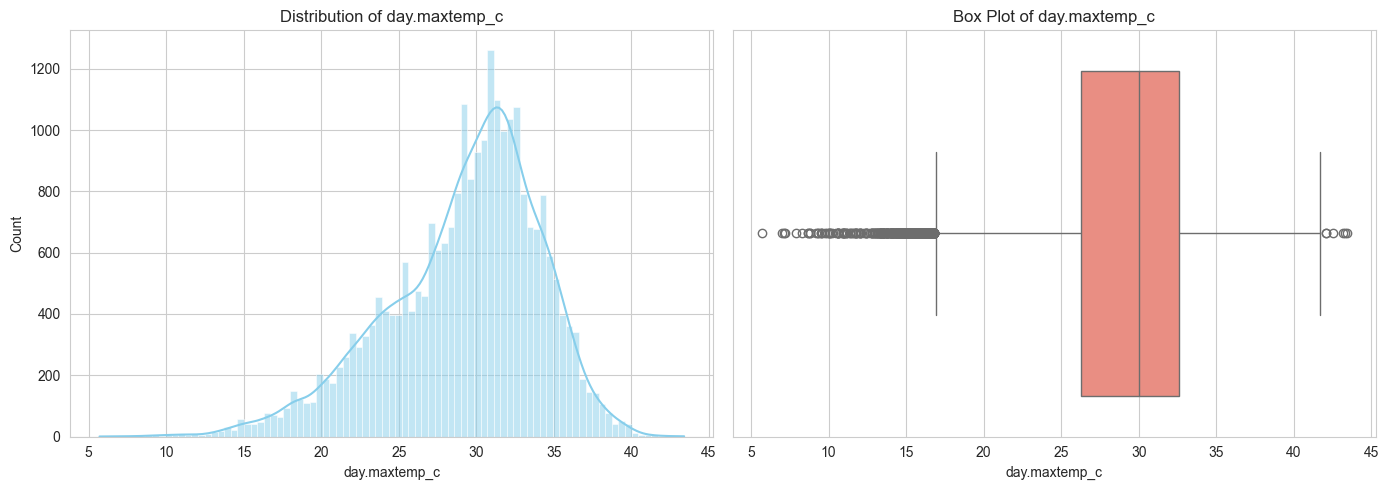



Analysis for: day.mintemp_c
Mean: 22.07 | Median: 23.50 | Std: 4.37
Min: -0.20 | Max: 30.70
Skewness: -1.14 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 814 rows (3.16%)
Reasonable Range (Expected): 11.95 to 33.15


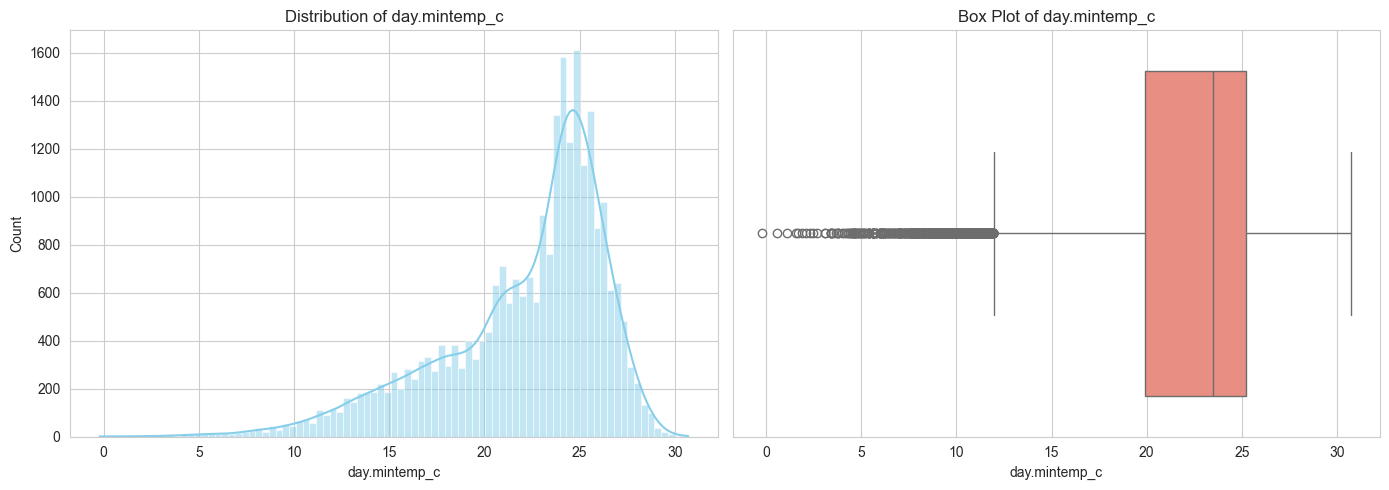



Analysis for: day.avgtemp_c
Mean: 25.06 | Median: 26.10 | Std: 4.29
Min: 3.80 | Max: 35.30
Skewness: -1.01 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 665 rows (2.58%)
Reasonable Range (Expected): 14.85 to 36.05


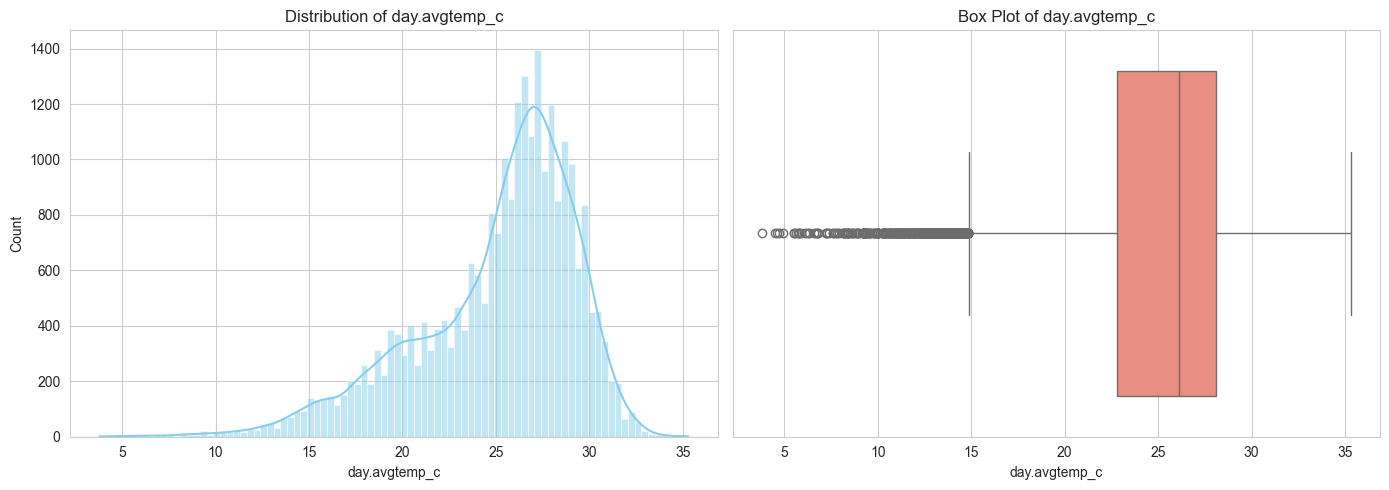

In [71]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

def analyze_numerical_column(df, col):
    print(f"Analysis for: {col}")
    
    # 1. Central Tendency & Distribution Stats
    desc = df[col].describe()
    skewness = df[col].skew()
    kurtosis = df[col].kurt()
    missing_pct = df[col].isnull().mean() * 100
    
    print(f"Mean: {desc['mean']:.2f} | Median: {desc['50%']:.2f} | Std: {desc['std']:.2f}")
    print(f"Min: {desc['min']:.2f} | Max: {desc['max']:.2f}")
    print(f"Skewness: {skewness:.2f} (0=Normal, >0=Right Skewed, <0=Left Skewed)")
    print(f"Missing Values: {missing_pct:.2f}%")
    
    # 2. Outlier Detection (IQR Method)
    Q1 = desc['25%']
    Q3 = desc['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_pct = (outliers_count / len(df)) * 100
    
    print(f"Outliers (IQR method): {outliers_count} rows ({outliers_pct:.2f}%)")
    print(f"Reasonable Range (Expected): {lower_bound:.2f} to {upper_bound:.2f}")
    
    # 3. Visualizations
    fig, axes = plt.subplots(1, 2)
    
    # Histogram + KDE (Distribution Shape)
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {col}')
    
    # Box Plot (Outliers)
    sns.boxplot(data=df, x=col, ax=axes[1], color='salmon')
    axes[1].set_title(f'Box Plot of {col}')
    
    plt.tight_layout()
    plt.show()
    print("\n" + "="*80 + "\n")

# Define Numerical Columns list based on the previous cleaning
# Remove 'location.lat', 'location.lon' as not providing meanings
# for distribution & range and outliers & data quality
# but can be used for meaningful questions/insights 
numerical_cols_1 = [
    'day.maxtemp_c', 'day.mintemp_c', 'day.avgtemp_c'
]

# Execute Analysis
for col in numerical_cols_1:
    analyze_numerical_column(df, col)
    

### Phân tích chi tiết: Nhóm cột Nhiệt độ (Temperature)
Dựa trên các biểu đồ histogram và boxplot, chúng ta có thể rút ra các nhận định sau về đặc điểm khí hậu trong bộ dữ liệu:

#### 1. Nhiệt độ thấp nhất trong ngày (day.mintemp_c)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch trái (Left Skewed) với độ lệch Skewness = -1.14.

##### Xu hướng tập trung:

- Trung bình (Mean): 22.07°C

- Trung vị (Median): 23.50°C

**Chú thích** Việc Mean < Median khẳng định xu hướng lệch trái: Đa số các ngày ở Việt Nam có nhiệt độ ban đêm khá ấm (khoảng 23-25°C), nhưng có một số ngày mùa đông rất lạnh kéo mức trung bình xuống.

##### Phạm vi & Giá trị ngoại lai (Range & Outliers):

- Min: -0.2°C. Nhận xét: Đây là giá trị rất thấp đối với khí hậu nhiệt đới. Tuy nhiên, ở các vùng núi cao phía Bắc (như Mẫu Sơn, Fansipan) vào mùa đông, nhiệt độ xuống dưới 0°C là có thật. Do đó, đây khả năng cao là dữ liệu thật (extreme values) chứ không phải lỗi nhập liệu.

- Outliers: Có 814 dòng (3.16%) bị coi là ngoại lai theo phương pháp IQR (các chấm tròn bên trái biểu đồ Box Plot). Đây chủ yếu là các ngày mùa đông lạnh (dưới 12°C).

- Max: 30.7°C (đêm mùa hè rất nóng).

#### 2. Nhiệt độ trung bình trong ngày (day.avgtemp_c)
##### Phân phối (Distribution):

- Hình dạng: Vẫn là Lệch trái (Left Skewed) (Skewness = -1.01). Đỉnh của biểu đồ (Mode) tập trung dày đặc ở khoảng 26°C - 28°C.

- Đặc điểm: Dải nhiệt độ phổ biến nhất phản ánh đúng khí hậu nóng ẩm của Việt Nam.

##### Phạm vi & Giá trị ngoại lai:

- Range: Từ 3.8°C đến 35.3°C.

- Min (3.8°C): Rất lạnh, phù hợp với các đợt rét đậm, rét hại ở miền Bắc.

- Max (35.3°C): Đây là nhiệt độ trung bình cả ngày, nên mức 35.3°C là cực kỳ nóng (nghĩa là cả ngày lẫn đêm đều hầm hập).

- Outliers: 665 dòng (2.58%). Tương tự như trên, đây là các ngày lạnh bất thường so với mặt bằng chung, không nên xóa bỏ vì chúng mang ý nghĩa dự báo thiên tai/rét đậm.

#### 3. Nhiệt độ cao nhất trong ngày (day.maxtemp_c)
- Phân phối (Distribution):

- Hình dạng: Lệch trái nhẹ (Skewness = -0.70).

- Biến động: Độ lệch chuẩn (Std) là 4.92, cao nhất trong 3 cột nhiệt độ, cho thấy nhiệt độ ban ngày giữa các mùa/vùng miền có sự chênh lệch lớn hơn so với ban đêm.

**Phạm vi & Giá trị ngoại lai**:

- Max: 43.4°C. Nhận xét: Con số này rất cao nhưng hợp lý với bối cảnh biến đổi khí hậu gần đây (năm 2023-2024, các trạm ở Tương Dương, Nghệ An đã ghi nhận kỷ lục >44°C).

- Min: 5.7°C. Một ngày mà nhiệt độ cao nhất chỉ đạt 5.7°C thì đó là ngày cực kỳ rét buốt (thường là vùng núi cao).

- Outliers: 440 dòng (1.71%). Số lượng ngoại lai ít hơn so với nhiệt độ thấp nhất, cho thấy cái nóng ở Việt Nam đồng đều hơn cái lạnh.

**Kết luận chung (Actionable Insights)**
- Chất lượng dữ liệu (Data Quality):

- Missing Values: 0.00% (Rất tốt, dữ liệu đầy đủ).

- Tính hợp lý: Các giá trị Min/Max (Min ~ -0.2°C, Max ~ 43.4°C) tuy thoạt nhìn có vẻ cực đoan nhưng hoàn toàn phù hợp với dữ liệu khí tượng thực tế của Việt Nam trải dài từ Bắc vào Nam và bao gồm cả vùng núi cao. Không có dấu hiệu lỗi nhập liệu (như 999 hay -100).

**Xử lý Outliers:**

Mặc dù phương pháp IQR đánh dấu khoảng 2-3% dữ liệu là "Outliers" (các chấm đen bên trái biểu đồ Box Plot), nhưng KHÔNG ĐƯỢC XÓA các dòng này.

Lý do: Đây là các hiện tượng thời tiết cực đoan (Rét đậm, rét hại). **Trong bài toán dự báo thời tiết, việc dự đoán đúng các ngày "ngoại lai" này quan trọng hơn nhiều so với dự đoán các ngày bình thường.**

**Feature Engineering:**

Vì phân phối bị lệch (Skewed), khi mô hình hóa (Machine Learning), ta có thể cân nhắc không cần chuẩn hóa Log (Log transform) vì độ lệch không quá lớn (chỉ quanh mức -1). Tuy nhiên, các mô hình cây quyết định (Decision Tree, Random Forest) sẽ xử lý tốt dạng dữ liệu này mà không cần biến đổi nhiều.


Analysis for: day.maxwind_kph
Mean: 15.13 | Median: 14.80 | Std: 6.10
Min: 1.40 | Max: 81.60
Skewness: 0.66 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 293 rows (1.14%)
Reasonable Range (Expected): -1.35 to 31.05


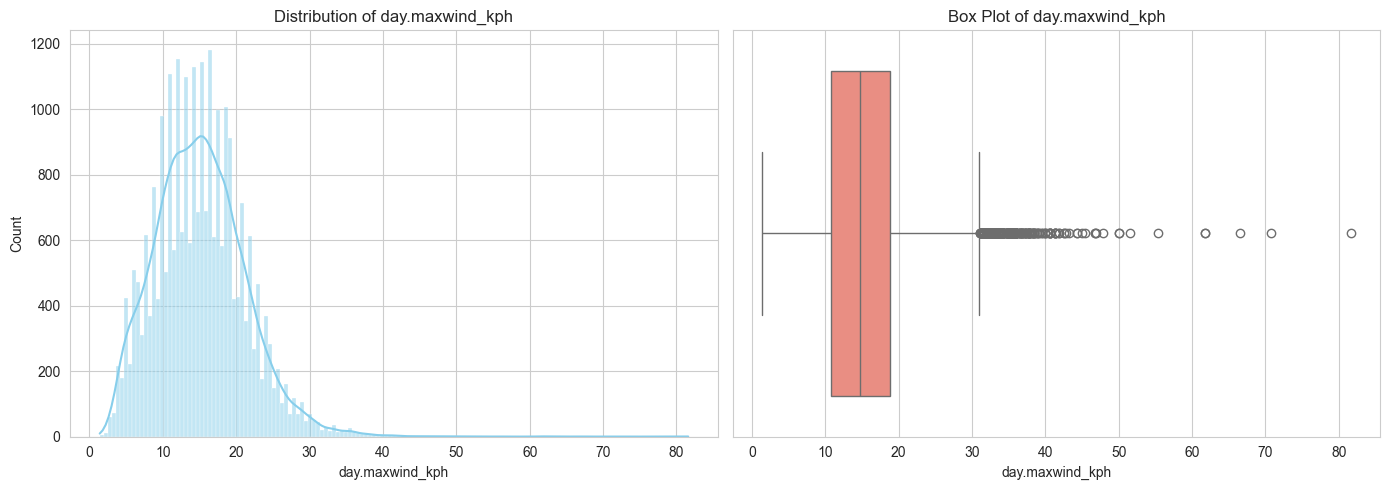



Analysis for: day.totalprecip_mm
Mean: 6.65 | Median: 1.60 | Std: 12.99
Min: 0.00 | Max: 285.20
Skewness: 6.14 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 2187 rows (8.49%)
Reasonable Range (Expected): -12.58 to 20.98


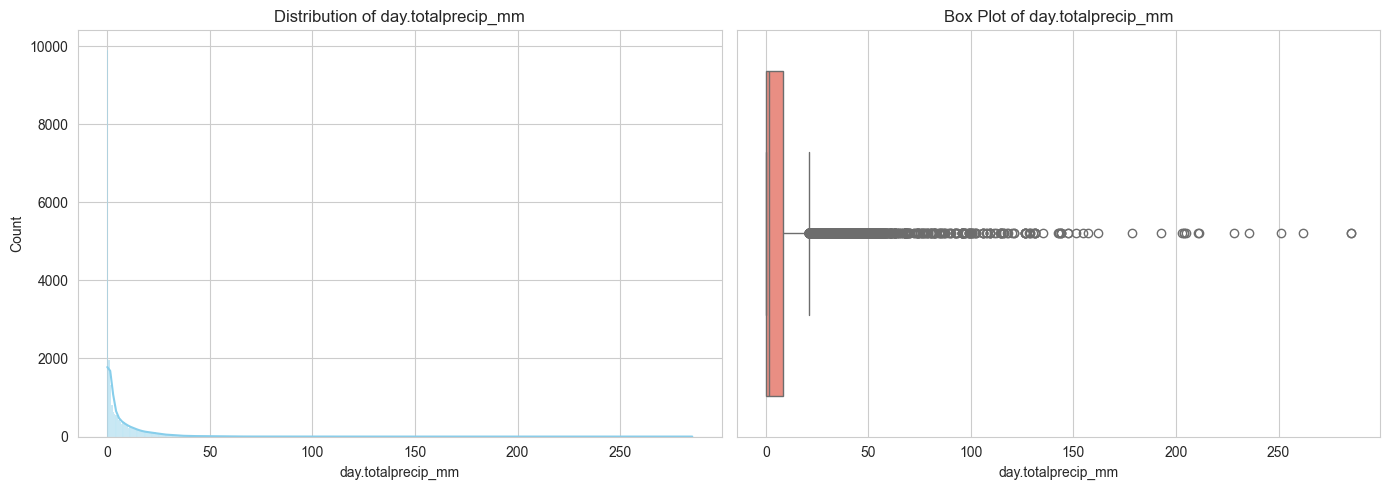

In [72]:
numerical_cols_2 = [
    'day.maxwind_kph', 'day.totalprecip_mm'
]

# Execute Analysis
for col in numerical_cols_2:
    analyze_numerical_column(df, col)
    

## Phân tích chi tiết:
#### 1. Lượng mưa trong ngày (day.totalprecip_mm)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch phải cực độ (Extreme Right Skewed).

- Zero-inflated (Lạm phát số 0): Biểu đồ Histogram có một cột dựng đứng rất cao ở giá trị 0. Điều này phản ánh đúng thực tế: Trong một năm, số ngày không mưa (nắng ráo) hoặc mưa không đáng kể thường chiếm đa số.

#### Phạm vi & Giá trị ngoại lai (Outliers):

- Outliers: Biểu đồ Box Plot (bên phải) hiển thị một dải dày đặc các chấm tròn (outliers) kéo dài từ khoảng 20mm đến gần 300mm.

**Giải thích: Theo thống kê thông thường (IQR), bất kỳ ngày nào mưa trên ~20mm đã bị coi là ngoại lai. Tuy nhiên, ở Việt Nam (khí hậu nhiệt đới gió mùa), các trận mưa lớn từ 50mm - 100mm, thậm chí 200mm - 300mm (trong bão) là chuyện bình thường.**

- Max: Giá trị cao nhất đạt gần 280-300mm. Đây là lượng mưa rất lớn, thường thấy trong các đợt áp thấp nhiệt đới hoặc bão đổ bộ vào miền Trung/miền Bắc.

**Kết luận: Dữ liệu này hợp lệ. Không được xử lý ngoại lai theo cách thông thường (xóa bỏ hoặc quy về giá trị trần), vì chính những giá trị "outlier" này là mục tiêu quan trọng để dự báo ngập lụt.**

#### 2. Tốc độ gió tối đa (day.maxwind_kph)
##### Phân phối (Distribution):

- Hình dạng: Phân phối khá cân đối nhưng vẫn Lệch phải nhẹ (Right Skewed) với Skewness = 0.66.

**Xu hướng tập trung:**

- Trung bình (Mean): 15.13 km/h.

- Trung vị (Median): 14.80 km/h.

**Nhận xét: Tốc độ gió trung bình khoảng 15 km/h tương đương với Gió cấp 3 (Gió nhẹ), là điều kiện thời tiết bình thường hàng ngày.**

##### Phạm vi & Giá trị ngoại lai:

- Min (1.40 km/h): Gió lặng, rất hợp lý.

- Max (81.60 km/h): Con số này tương đương Gió cấp 9 (Gió mạnh/Nhiệt đới) trên thang Beaufort. Đây là dấu hiệu rõ ràng của giông lốc mạnh hoặc ảnh hưởng của bão.

- Outliers: Có 293 dòng (1.14%) vượt ngưỡng ~31 km/h. Đây là các ngày có gió mùa Đông Bắc mạnh hoặc thời tiết xấu.

**Kết luận: Dải dữ liệu từ 1.4 đến 81.6 km/h hoàn toàn nằm trong giới hạn vật lý của thời tiết Việt Nam. Các giá trị cao là tín hiệu tốt để mô hình học được các điều kiện thời tiết nguy hiểm.**

### Tổng kết chung
- Chất lượng dữ liệu rất tốt: Không có giá trị vô lý về mặt vật lý (như mưa âm, tốc độ gió âm, hay nhiệt độ 1000 độ).

- Đặc tính chung: Hầu hết các dữ liệu khí tượng (Mưa, Gió) đều bị lệch phải (Right Skewed) do tính chất khắc nghiệt thỉnh thoảng mới xảy ra của thiên nhiên.

Chiến lược cho bước Modelling:

- Đối với Lượng mưa: Đây là dữ liệu khó dự báo nhất do có quá nhiều số 0. Khi mô hình hóa, cân nhắc chuyển bài toán thành Phân loại (Mưa/Không mưa) trước, sau đó mới Hồi quy lượng mưa (Regression) cho những ngày có mưa.

Analysis for: day.avgvis_km
Mean: 9.17 | Median: 9.70 | Std: 1.27
Min: 0.00 | Max: 10.00
Skewness: -2.15 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 2410 rows (9.35%)
Reasonable Range (Expected): 7.25 to 11.65


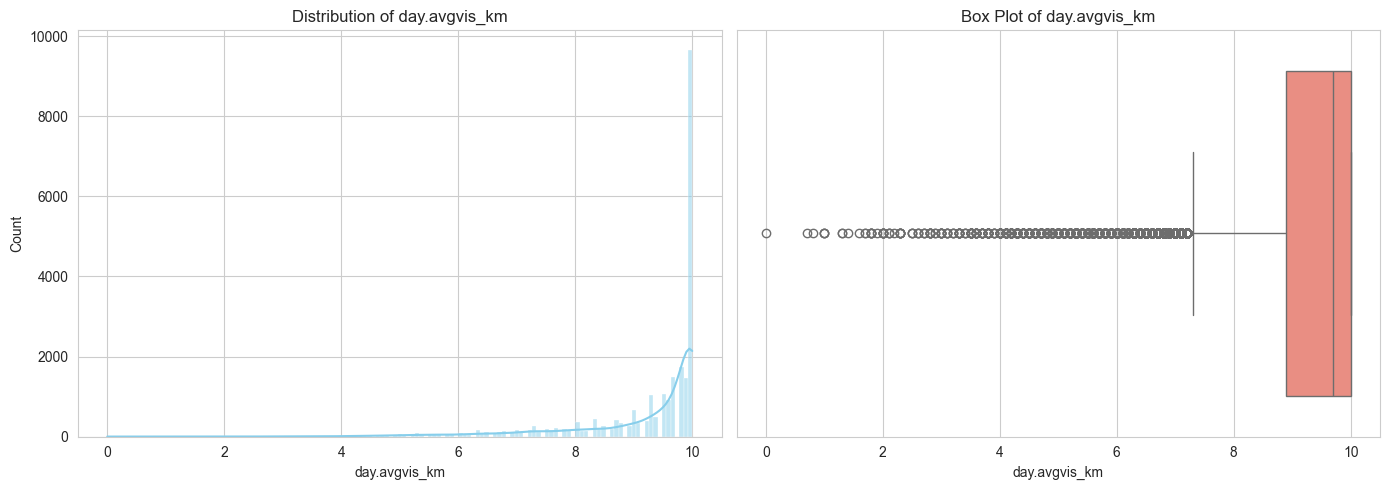



Analysis for: day.avghumidity
Mean: 76.84 | Median: 79.00 | Std: 11.40
Min: 24.00 | Max: 100.00
Skewness: -0.71 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 395 rows (1.53%)
Reasonable Range (Expected): 47.50 to 107.50


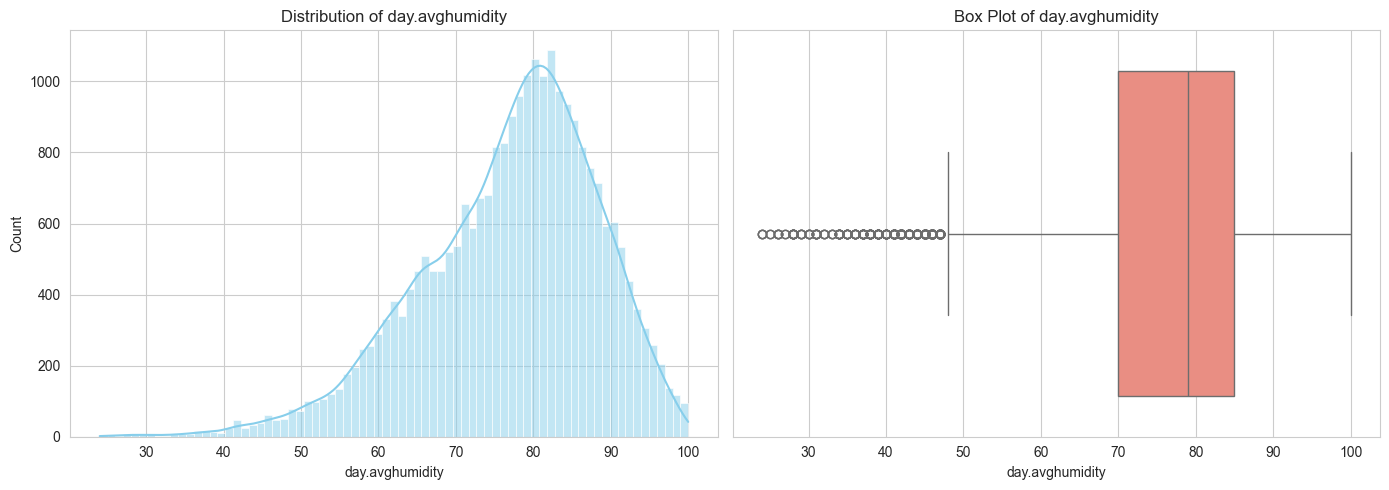



Analysis for: day.uv
Mean: 6.48 | Median: 7.00 | Std: 1.10
Min: 2.00 | Max: 10.00
Skewness: -0.39 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 1748 rows (6.78%)
Reasonable Range (Expected): 4.50 to 8.50


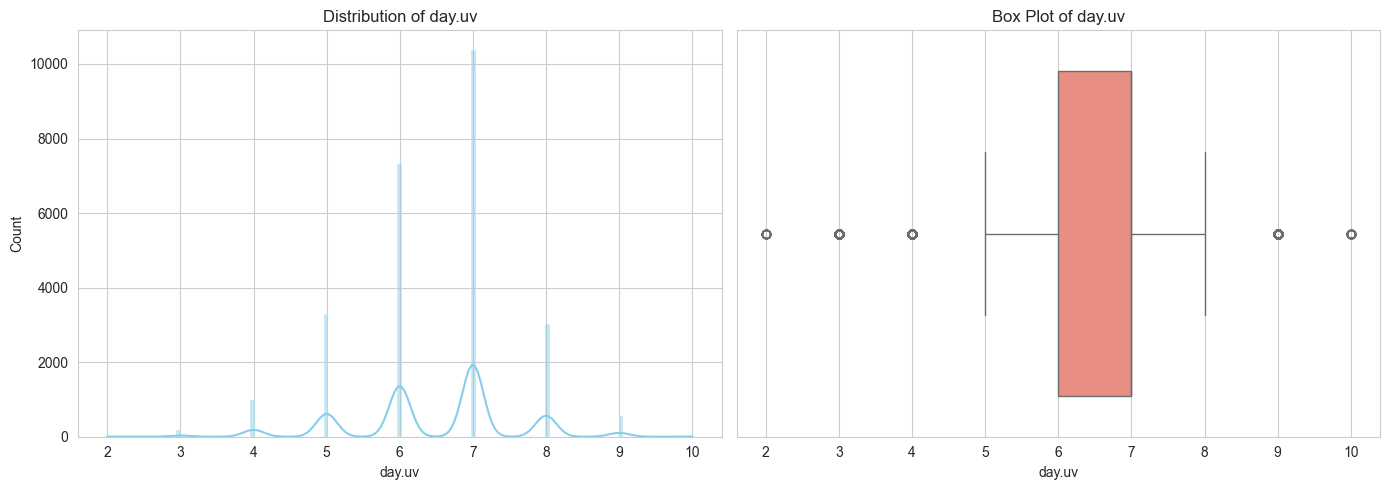

In [73]:
numerical_cols_3 = [
    'day.avgvis_km', 'day.avghumidity', 
    'day.uv'
]

# Execute Analysis
for col in numerical_cols_3:
    analyze_numerical_column(df, col)


## Phân tích chi tiết cho: Tầm nhìn (day.avgvis_km), Độ ẩm (day.avghumidity), và Chỉ số UV (day.uv).
#### 1. Tầm nhìn trung bình (day.avgvis_km)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch trái mạnh (Strongly Left Skewed) với Skewness = -2.15.

- Hiện tượng "Trần dữ liệu" (Ceiling Effect): Biểu đồ Histogram có một cột dựng đứng rất cao ở giá trị cực đại 10.0 km.

**Giải thích: Trong các báo cáo khí tượng, tầm nhìn thường được đo tối đa là 10km (hoặc ghi là "10km+"). Tức là dù trời trong xanh nhìn xa 20km thì dữ liệu vẫn chỉ ghi là 10km. Do đó, phân phối này hoàn toàn bình thường do giới hạn của thiết bị đo/API.**

#### Phạm vi & Giá trị ngoại lai (Outliers):

- Trung bình: 9.17 km (Rất gần với mức tối đa, cho thấy đa số thời gian tầm nhìn ở VN khá tốt).

- Outliers: Có tới 9.35% dữ liệu bị coi là ngoại lai (nằm bên trái biểu đồ Box Plot, dưới 7.25 km).

**Ý nghĩa: Những "outliers" này (tầm nhìn thấp < 5km, thậm chí 0-2km) đại diện cho những ngày có sương mù dày đặc, mưa lớn hoặc ô nhiễm không khí nặng. Đây là những đặc trưng quan trọng cần giữ lại để phân tích chất lượng không khí hoặc an toàn giao thông.**

#### 2. Độ ẩm trung bình (day.avghumidity)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch trái (Left Skewed) với Skewness = -0.71. Đỉnh phân phối lệch về phía các giá trị cao (khoảng 80%).

- Đặc tính khí hậu: Trung vị (Median) là 79%, phản ánh chính xác đặc điểm khí hậu nhiệt đới gió mùa nóng ẩm của Việt Nam.

##### Phạm vi & Giá trị ngoại lai:

- Max (100%): Độ ẩm bão hòa, thường xảy ra vào những ngày mưa dầm hoặc nồm ẩm (đặc biệt ở miền Bắc).

- Min (24%): Độ ẩm rất thấp. Lưu ý: Mặc dù hiếm, nhưng các vùng như Ninh Thuận, Bình Thuận vào mùa khô hoặc những ngày chịu ảnh hưởng của gió Lào (gió Phơn) khô nóng thì độ ẩm xuống dưới 30-40% là có thể xảy ra.

- Outliers: Các chấm tròn bên trái (độ ẩm thấp) được coi là ngoại lai. Tuy nhiên, trong bối cảnh dữ liệu khí tượng, đây là dấu hiệu của các đợt nắng nóng cực đoan/khô hạn.

#### 3. Chỉ số UV (day.uv)
##### Phân phối (Distribution):

- Hình dạng: Biểu đồ Histogram có dạng Đa đỉnh (Multimodal) và bị ngắt quãng (rời rạc). Các cột cao tập trung ở các giá trị nguyên như 5, 6, 7, 8.

**Nhận xét về dữ liệu: Điều này cho thấy nguồn dữ liệu gốc (API) trả về chỉ số UV dưới dạng số nguyên (integer) hoặc làm tròn, thay vì số thực liên tục.**

##### Phạm vi & Giá trị ngoại lai:

- Trung bình: 6.48. Theo thang đo UV, mức 6-7 là mức "Cao" (High). Điều này hợp lý với một quốc gia nằm gần xích đạo và có số giờ nắng cao như VN.

- Max (10.00): Mức "Rất cao" (Very High), gây nguy hại cho da nếu tiếp xúc trực tiếp.

- Outliers: Có khoảng 6.78% dữ liệu là ngoại lai, tập trung ở các giá trị thấp (2, 3). Đây thường là những ngày mưa bão, trời âm u dày đặc mây nên chỉ số UV thấp.

### Tổng kết chung
Sau khi phân tích toàn bộ các biến số (Nhiệt, Mưa, Gió, Độ ẩm, UV, Tầm nhìn), chúng ta có bức tranh tổng thể:

**Mối tương quan tiềm năng (Correlations):**

- day.avgvis_km thấp (tầm nhìn kém) khả năng cao sẽ tương quan mạnh với day.avghumidity cao (sương mù) hoặc day.totalprecip_mm cao (mưa to).

- day.uv cao (nắng to) sẽ tương quan nghịch với day.avghumidity và day.totalprecip_mm.

- Độ sạch của dữ liệu: Dữ liệu số học cực kỳ sạch sẽ, không có giá trị rác (như số âm cho lượng mưa hay độ ẩm >100%).

**Khi Feature Engineering:**

- Biến day.avgvis_km: Do bị chặn trần ở 10km, biến này có thể ít nhạy (less sensitive) trong việc phân biệt các ngày "trời đẹp". Nó sẽ hữu ích hơn trong việc phát hiện "thời tiết xấu".

- Biến day.uv: Do dữ liệu có tính rời rạc (làm tròn số), nó có thể hoạt động tốt nếu được chuyển đổi thành biến phân loại (Ordinal Category) như: Thấp, Trung bình, Cao, Cực cao thay vì để dạng số thực.

## Categorical Columns Analysis

Analysis for: location.name
Unique Values: 63
Missing Values: 0.00%
Top 10 Most Frequent Values:
location.name
An Giang      409
Thái Bình     409
Ninh Bình     409
Ninh Thuận    409
Phú Thọ       409
Phú Yên       409
Quảng Bình    409
Quảng Nam     409
Quảng Ngãi    409
Quảng Ninh    409
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 1.00 (1.0 = Perfectly Balanced)


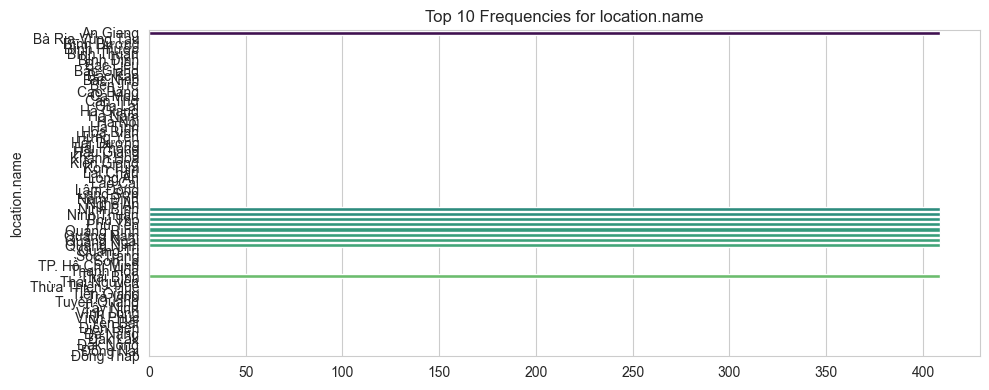



Analysis for: location.region
Unique Values: 7
Missing Values: 0.00%
Top 10 Most Frequent Values:
location.region
Bắc Trung Bộ và Duyên hải miền Trung    5726
Trung du và miền núi Bắc Bộ             5317
Đồng Bằng Sông Cửu Long                 5317
Đồng Bằng Sông Hồng                     4498
Đông Nam Bộ                             2454
Tây Nguyên                              2045
Tr [*]ung du và miền núi Bắc Bộ          409
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 14.00 (1.0 = Perfectly Balanced)


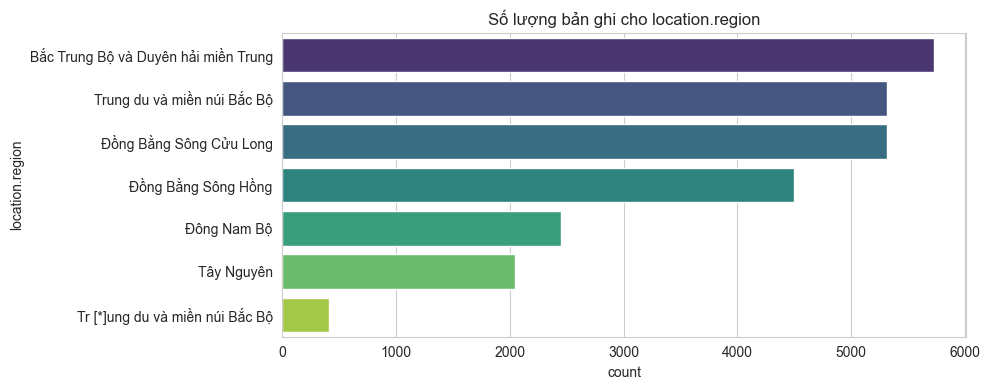

All Unique Categories: ['Bắc Trung Bộ và Duyên hải miền Trung', 'Tr [*]ung du và miền núi Bắc Bộ', 'Trung du và miền núi Bắc Bộ', 'Tây Nguyên', 'Đông Nam Bộ', 'Đồng Bằng Sông Cửu Long', 'Đồng Bằng Sông Hồng']


Analysis for: day.daily_will_it_rain
Unique Values: 2
Missing Values: 0.00%
Top 10 Most Frequent Values:
day.daily_will_it_rain
True     19088
False     6678
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 2.86 (1.0 = Perfectly Balanced)


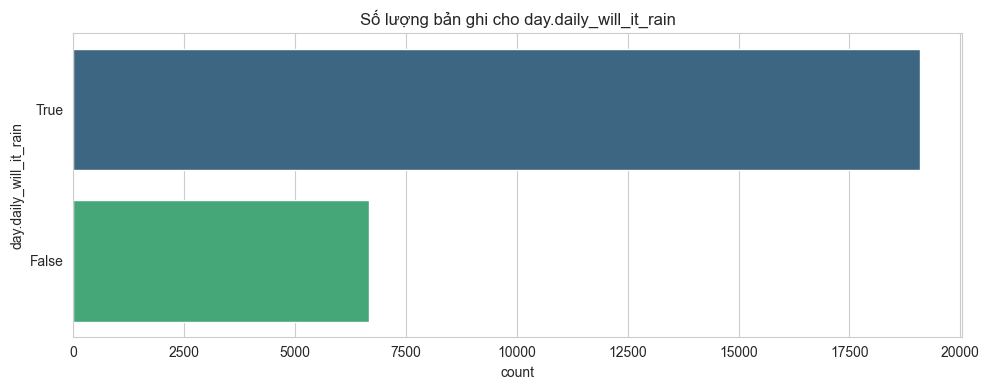

In [74]:
def analyze_categorical_column(df, col):
    print(f"Analysis for: {col}")
    
    # 1. Value Distribution Stats
    unique_count = df[col].nunique()
    missing_pct = df[col].isnull().mean() * 100
    
    print(f"Unique Values: {unique_count}")
    print(f"Missing Values: {missing_pct:.2f}%")
    
    # Top Frequent Values
    top_counts = df[col].value_counts().head(10)
    print("Top 10 Most Frequent Values:")
    print(top_counts)
    
    # Balance Check (Ratio of Top to Bottom frequency)
    if unique_count > 1:
        balance_ratio = df[col].value_counts().max() / df[col].value_counts().min()
        print(f"Imbalance Ratio (Max/Min count): {balance_ratio:.2f} (1.0 = Perfectly Balanced)")
    
    # 2. Visualizations
    plt.figure(figsize=(10, 4))
    
    if unique_count > 10:
        # If too many categories, plot only top 10
        sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis')
        plt.title(f'Top 10 Frequencies for {col}')
    else:
        sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Số lượng bản ghi cho {col}')
        
    plt.tight_layout()
    plt.show()
    
    # 3. Inconsistency Check (Quick heuristic for text columns)
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # Check for similar strings that might be typos (e.g., "Hanoi" vs "Ha Noi" - basic check)
        # This just prints the raw unique values sorted to spot duplicates visually
        unique_vals = sorted(df[col].dropna().unique().astype(str))
        if len(unique_vals) < 50:
            print(f"All Unique Categories: {unique_vals}")
    
    print("\n" + "="*80 + "\n")

# Define Categorical Columns based on previous steps
categorical_cols = [
    'location.name', 'location.region'
]
# Note: 'day.daily_will_it_rain' is boolean but acts like categorical
categorical_cols.append('day.daily_will_it_rain')

# Execute Analysis
for col in categorical_cols:
    if col in df.columns:
        analyze_categorical_column(df, col)

Dữ liệu cho thấy sự cân bằng tuyệt đối: mỗi tỉnh thành trong số 63 tỉnh của Việt Nam đều có chính xác 409 dòng dữ liệu.

- Không có "Top" thực sự: Khi tất cả 63 tỉnh đều có số lượng bằng nhau, khái niệm "Top 10 xuất hiện nhiều nhất" trở nên vô nghĩa (vì ai cũng là hạng nhất).

- Vấn đề hiển thị: Do tất cả đều bằng nhau, biểu đồ cố gắng hiển thị danh sách (có thể là theo thứ tự bảng chữ cái), làm cho các nhãn tên tỉnh bị chồng chéo lên nhau nếu khung hình không đủ lớn.

**Ý nghĩa con số 409:** đại diện cho số ngày thu thập dữ liệu.

=> Điều này xác nhận rằng quy trình thu thập dữ liệu (Data Collection) đã hoạt động hoàn hảo: Không có tỉnh nào bị mất ngày nào so với tỉnh khác. Dữ liệu đồng bộ trên toàn quốc từ ngày đầu đến ngày cuối.

**Kết luận cho cột này:**

- Dữ liệu Sạch 100%: Không cần xử lý mất cân bằng (imbalanced data).

- Hành động: Chúng ta không cần làm gì thêm với cột này về mặt làm sạch.

Analysis for: location.terrain
Unique Values: 3
Missing Values: 0.00%
Top 10 Most Frequent Values:
location.terrain
ven biển     10633
miền núi      8180
đồng bằng     6953
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 1.53 (1.0 = Perfectly Balanced)


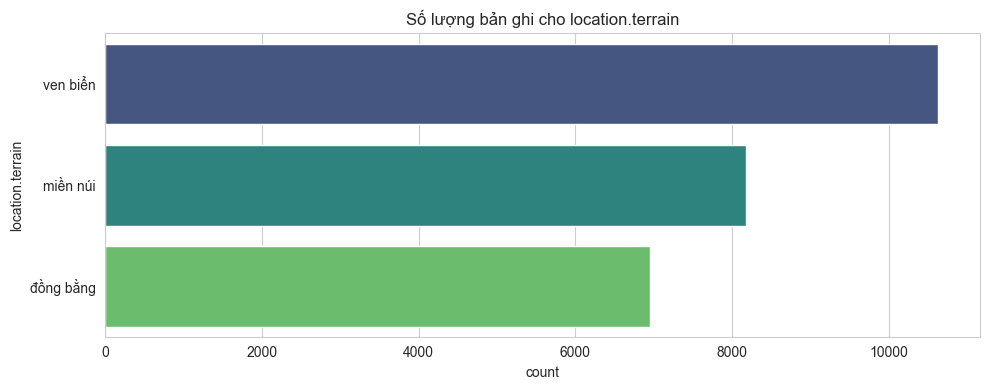

All Unique Categories: ['miền núi', 'ven biển', 'đồng bằng']


Analysis for: day.condition.text
Unique Values: 21
Missing Values: 0.00%
Top 10 Most Frequent Values:
day.condition.text
Moderate or heavy rain shower     7280
Patchy rain possible              6062
Overcast                          2639
Moderate rain at times            2069
Partly cloudy                     1969
Sunny                             1516
Heavy rain at times               1434
Cloudy                            1212
Light rain shower                  976
Patchy light rain with thunder     189
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 7280.00 (1.0 = Perfectly Balanced)


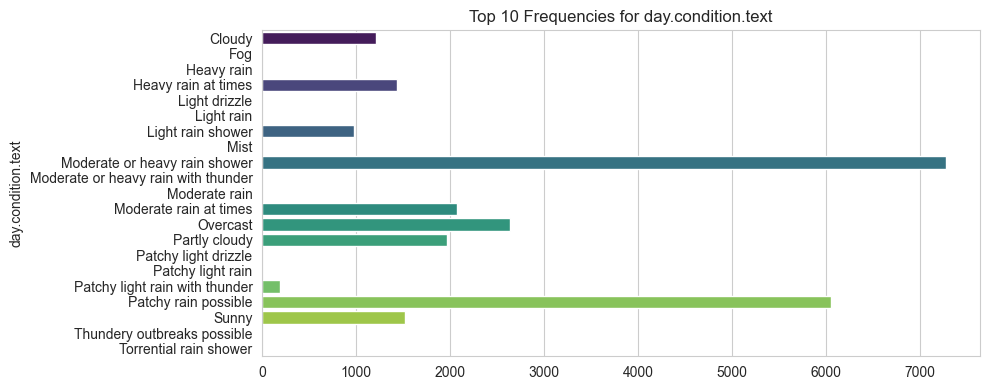

All Unique Categories: ['Cloudy', 'Fog', 'Heavy rain', 'Heavy rain at times', 'Light drizzle', 'Light rain', 'Light rain shower', 'Mist', 'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder', 'Moderate rain', 'Moderate rain at times', 'Overcast', 'Partly cloudy', 'Patchy light drizzle', 'Patchy light rain', 'Patchy light rain with thunder', 'Patchy rain possible', 'Sunny', 'Thundery outbreaks possible', 'Torrential rain shower']


Analysis for: day.condition.code
Unique Values: 21
Missing Values: 0.00%
Top 10 Most Frequent Values:
day.condition.code
1243    7280
1063    6062
1009    2639
1186    2069
1003    1969
1000    1516
1192    1434
1006    1212
1240     976
1273     189
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 7280.00 (1.0 = Perfectly Balanced)


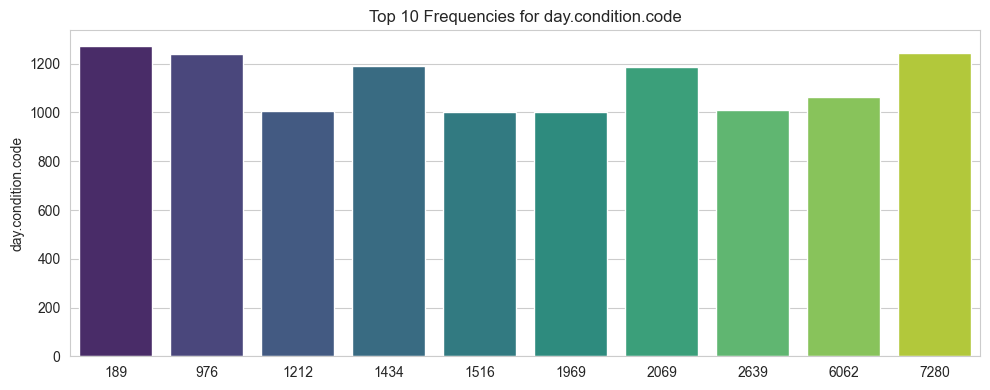

In [75]:
# Define Categorical Columns based on previous steps
categorical_cols_2 = [
    'location.terrain', 
    'day.condition.text', 'day.condition.code'
]

# Execute Analysis
for col in categorical_cols_2:
    if col in df.columns:
        analyze_categorical_column(df, col)

#### 1. Phân tích Biến Phân loại: Địa hình (location.terrain)

##### Phân phối giá trị (Value Distribution):

- Ven biển: 10,633 dòng (Chiếm tỷ trọng cao nhất).

- Miền núi: 8,180 dòng.

- Đồng bằng: 6,953 dòng.

**Nhận xét:**

Tính cân bằng: Tỷ lệ mất cân bằng (Imbalance Ratio) là 1.53. Đây là một tỷ lệ rất tốt (gần 1). Dữ liệu phân bố khá đều giữa 3 loại địa hình, phản ánh đúng đặc thù địa lý của Việt Nam (bờ biển dài, nhiều đồi núi).

Ý nghĩa xây mô hình: Không cần kỹ thuật cân bằng dữ liệu (như SMOTE). Biến này rất tốt để so sánh sự khác biệt khí hậu (ví dụ: So sánh gió ở "Ven biển" vs "Miền núi").

#### 2. Phân tích Biến Phân loại: Kiểu thời tiết (day.condition.text)

- Sự đa dạng: Có 21 kiểu thời tiết khác nhau (Unique values).

##### Top các kiểu thời tiết phổ biến nhất:

- Moderate or heavy rain shower (Mưa rào vừa hoặc to): 7,280 lần (Cao vượt trội).

- Patchy rain possible (Có thể có mưa rải rác): 6,062 lần.

- Overcast (U ám): 2,639 lần.

...

- Sunny (Nắng): Chỉ đứng thứ 6 với 1,516 lần.

#### Vấn đề & Giải pháp:

- Quá chi tiết (Too Granular): Có quá nhiều loại "Mưa" (Mưa rào, mưa lất phất, mưa to, mưa kèm sấm...). Điều này làm **loãng dữ liệu**.

Ta nên **gom nhóm** các giá trị này lại để mô hình dễ học hơn. 3 nhóm:

- Nhóm 1 (Mưa): Moderate rain, Light rain, Heavy rain... -> Gộp thành "Rain".

- Nhóm 2 (Mây/Âm u): Overcast, Cloudy, Partly cloudy -> Gộp thành "Cloudy".

- Nhóm 3 (Nắng/Đẹp): Sunny -> "Clear/Sunny".

#### Kết luận & Bước tiếp theo
- Xử lý day.condition.text: Đây là việc quan trọng nhất. Cần viết hàm để gom 21 loại thời tiết về 3-4 nhóm chính (Mưa, Mây, Nắng).

##### Feature Engineering:

- Tạo cột **is_rainy** (Có mưa không?) từ **day.totalprecip_mm**.

- Tạo cột **season** (Mùa) từ cột date để phân tích sự khác biệt khí hậu theo mùa.

## Missing Data Analysis


Missing values summary:
------------------------------------------------------------
Bộ dữ liệu không có bất kỳ giá trị bị thiếu nào (0 missing values).
------------------------------------------------------------
                 Column Name  Missing Count  Percentage (%)
0              location.name              0             0.0
1            location.region              0             0.0
2           location.terrain              0             0.0
3               location.lat              0             0.0
4               location.lon              0             0.0
5                       date              0             0.0
6              day.maxtemp_c              0             0.0
7              day.mintemp_c              0             0.0
8              day.avgtemp_c              0             0.0
9            day.maxwind_kph              0             0.0
10        day.totalprecip_mm              0             0.0
11             day.avgvis_km              0             0.0
12    

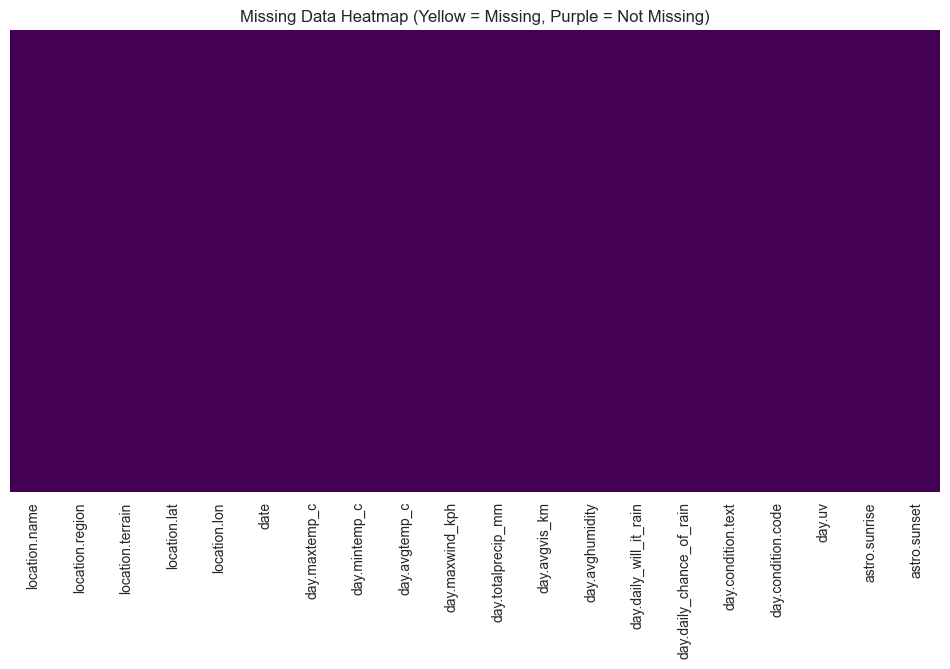

In [76]:
# --- 3. Missing Data Analysis ---

# 1. Create a missing values summary
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column Name', 'Missing Count']
missing_data['Percentage (%)'] = (missing_data['Missing Count'] / len(df)) * 100

# Lọc ra các cột có dữ liệu thiếu (nếu có) để hiển thị, hoặc hiển thị top 5 nếu tất cả đều bằng 0
print("Missing values summary:")
print("-" * 60)
if missing_data['Missing Count'].sum() == 0:
    print("Bộ dữ liệu không có bất kỳ giá trị bị thiếu nào (0 missing values).")
    print("-" * 60)
    print(missing_data)
else:
    print(missing_data[missing_data['Missing Count'] > 0])

# 2. Visualize missing data patterns
# Vì dữ liệu có thể không có missing, ta vẽ heatmap để chứng minh sự "sạch sẽ" của nó
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap (Yellow = Missing, Purple = Not Missing)')
plt.show()

# (Tùy chọn) Biểu đồ cột nếu có dữ liệu thiếu
if missing_data['Missing Count'].sum() > 0:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Percentage (%)', y='Column Name', data=missing_data[missing_data['Missing Count'] > 0], palette='Reds_r')
    plt.title('Percentage of Missing Values per Column')
    plt.show()

**Overall Assessment:**

Dựa trên biểu đồ Heatmap và bảng thống kê, bộ dữ liệu hoàn toàn sạch sẽ. Màu tím đồng nhất trên Heatmap cho thấy không có bất kỳ khoảng trống dữ liệu nào.

Không xác định được giá trị thiếu có ngẫu nhiên hay theo quy luật nào hay không vì không có giá trị bị thiếu.

**Per Column Strategy:**
*   **Observation:** Tất cả các cột đều có `Missing Count = 0` (0%).
*   **Reason:** Quy trình thu thập dữ liệu (Data Collection) qua API đã được thực hiện trọn vẹn, hoặc dữ liệu nguồn đã được xử lý trước khi tải lên Kaggle.
*   **Plan:** Không cần thực hiện các kỹ thuật xử lý dữ liệu thiếu (như Imputation hay Dropping rows). Dữ liệu đã sẵn sàng cho các bước phân tích tiếp theo.

### Cơ Chế Xử Lý Giá Trị Thiếu Nếu Có Trong Tương Lai

Mặc dù bộ dữ liệu hiện tại hoàn toàn đầy đủ (**0 missing values**), nhưng trong thực tế, dữ liệu thu thập trong tương lai (từ API hoặc các nguồn khác) có thể gặp lỗi đường truyền hoặc thiếu sót dẫn đến tồn tại giá trị bị thiếu.

Để đảm bảo tính bền vững cho quy trình xử lý dữ liệu (pipeline), nhóm thiết lập sẵn một hệ thống xử lý tự động với chiến lược khác nhau cho từng loại dữ liệu.

#### **Per-Column Strategy**
**Lý do lựa chọn thuật toán:**

**1. DateTime Columns → Forward Fill + Backward Fill**
   - **Nguyên nhân thiếu tiềm tàng:** Lỗi ghi nhận timestamp, mất đồng bộ thời gian hệ thống
   - **Chiến lược:** Forward Fill (ffill) kết hợp Backward Fill (bfill) dự phòng
   - **Lý do:** 
     * Dữ liệu thời gian có tính liên tục và tuần tự
     * Nếu thiếu ngày 15/12, ta giả định nó gần với ngày 14/12 (forward fill)
     * Nếu dòng đầu tiên thiếu (không có giá trị trước đó), dùng backward fill lấy từ dòng tiếp theo
   - **Công cụ:** `df[col].ffill()` và `df[col].bfill()`

**2. Categorical Columns → Mode Imputation**
   - **Nguyên nhân thiếu tiềm tàng:** Lỗi API, dữ liệu không áp dụng (N/A), lỗi mã hóa text
   - **Chiến lược:** Điền bằng giá trị xuất hiện nhiều nhất (Most Frequent / Mode)
   - **Lý do:** 
     * Không thể tính trung bình cho dữ liệu dạng text/category
     * Giá trị phổ biến nhất phản ánh xu hướng chung của dữ liệu
   - **Công cụ:** `SimpleImputer(strategy='most_frequent')`

**3. Numerical Columns → MICE với Decision Tree**
   - **Nguyên nhân thiếu tiềm tàng:** Lỗi cảm biến, mất tín hiệu, sự cố thiết bị đo đạc
   - **Chiến lược:** Model-Based Imputation sử dụng MICE (Multiple Imputation by Chained Equations)
   - **Lý do:** 
     * Dữ liệu thời tiết có mối quan hệ phi tuyến tính phức tạp:
       - Nhiệt độ cao + Độ ẩm thấp → Khả năng mưa thấp
       - Áp suất giảm + Tốc độ gió tăng → Khả năng có bão
       - Độ ẩm cao + Nhiệt độ thấp → Có thể xuất hiện sương mù
     * `DecisionTreeRegressor` nắm bắt các mẫu hình phi tuyến này tốt hơn hồi quy tuyến tính đơn thuần
     * `IterativeImputer` (MICE) sử dụng thông tin từ **tất cả** các cột số khác để dự đoán giá trị thiếu một cách chính xác qua nhiều vòng lặp (max_iter=10)
   - **Công cụ:** `IterativeImputer(estimator=DecisionTreeRegressor())`

#### **Plan:**

**Bước 1: Phát hiện và Phân loại**
- Quét toàn bộ DataFrame để phát hiện missing values
- Xác định loại dữ liệu của từng cột (datetime, categorical, numerical)
- Lọc ra các cột thực sự bị thiếu để tối ưu hiệu suất

**Bước 2: Áp Dụng Chiến Lược Tương Ứng**
- **Nếu datetime** → Forward Fill (ffill) → Nếu vẫn còn thiếu → Backward Fill (bfill)
- **Nếu categorical** → SimpleImputer với strategy='most_frequent'
- **Nếu numerical** → IterativeImputer (MICE + DecisionTreeRegressor)

**Bước 3: Kiểm Tra và Xác Nhận**
- Kiểm tra lại toàn bộ DataFrame
- Đảm bảo `remaining_missing = 0`
- Xác nhận các kiểu dữ liệu không bị thay đổi (đặc biệt là category type)


In [77]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor

print("Missing values predictor model")

# Kiểm tra tổng số lượng giá trị thiếu trong toàn bộ DataFrame
total_missing = df.isnull().sum().sum()

if total_missing > 0:
    print(f"Phát hiện {total_missing} giá trị bị thiếu. Đang tiến hành dự đoán và điền dữ liệu...")

    # Xử lý cột datetime
    # Chiến lược: Forward Fill (lấy ngày hôm trước điền cho ngày hôm sau)
    # Lý do: Thời gian thường liên tục, nếu thiếu thì khả năng cao là ngày kế tiếp.
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    
    # Chỉ xử lý cột có missing
    datetime_cols_missing = [col for col in datetime_cols if df[col].isnull().sum() > 0]

    if len(datetime_cols_missing) > 0:
        print(f"Đang xử lý cột thời gian (Forward Fill): {datetime_cols_missing}")
        for col in datetime_cols_missing:
            df[col] = df[col].ffill()
            
            # Nếu dòng đầu tiên bị thiếu (không có ngày trước đó), dùng bfill (Back Fill)
            if df[col].isnull().sum() > 0:
                 df[col] = df[col].bfill()


    # Xử lý các cột Phân loại (Categorical/Object/Boolean)
    # Chiến lược: Điền bằng giá trị xuất hiện nhiều nhất (Most Frequent / Mode)
    # Lý do: Không thể tính trung bình cộng cho chữ, nên ta chọn giá trị phổ biến nhất.
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
    
    # Chỉ xử lý các cột thực sự bị thiếu
    cat_cols_missing = [col for col in cat_cols if df[col].isnull().sum() > 0]
    
    if len(cat_cols_missing) > 0:
        print(f"Đang điền dữ liệu thiếu cho các cột phân loại (Mode): {cat_cols_missing}")
        cat_imputer = SimpleImputer(strategy='most_frequent')
        
        # Fit và Transform
        df[cat_cols_missing] = cat_imputer.fit_transform(df[cat_cols_missing])
        
        # SimpleImputer có thể làm mất kiểu 'category', convert lại nếu cần
        for col in cat_cols_missing:
             if df[col].dtype == 'object':
                df[col] = df[col].astype('category')
    # Xử lý cột số
    # Chiến lược: Model-based Imputation (Decision Tree)
    # IterativeImputer chỉ hoạt động trên các con số, không chạy được trên text/category
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    print(f"Các cột được sử dụng để tính toán: {list(numeric_cols)}")

    # Khởi tạo Imputer
    # Sử dụng DecisionTreeRegressor vì nó nắm bắt tốt các mối quan hệ phi tuyến tính trong thời tiết
    imputer = IterativeImputer(
        estimator=DecisionTreeRegressor(random_state=42),
        max_iter=10,
        random_state=42
    )

    # Fit và Transform (Học từ dữ liệu có sẵn -> Điền vào chỗ trống)
    # Chỉ áp dụng trên các cột số
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    print("Đã hoàn tất việc điền giá trị thiếu (Imputation Complete).")
    
    # Kiểm tra lại lần cuối
    remaining_missing = df.isnull().sum().sum()
    print(f"Số lượng giá trị thiếu còn lại: {remaining_missing}")

else:
    print("Dữ liệu hiện tại đầy đủ (0 missing values).")
    print("Bỏ qua bước Model-based Imputation.")

Missing values predictor model
Dữ liệu hiện tại đầy đủ (0 missing values).
Bỏ qua bước Model-based Imputation.


## Relationships & Correlations

**Feature Engineering:** Tạo thêm các cột mới để phân tích tương quan tốt hơn

In [78]:
# Trích xuất tháng từ ngày
df['month'] = df['date'].dt.month

# Tính biên độ nhiệt trong ngày
df['temperature_range'] = df['day.maxtemp_c'] - df['day.mintemp_c']

# Chuyển đổi Boolean sang Int để tính toán tương quan (True=1, False=0)
df['is_rainy'] = df['day.daily_will_it_rain'].astype(int)

print("Đã tạo thêm các cột: 'month', 'temperature_range', 'is_rainy'")
df.head()

Đã tạo thêm các cột: 'month', 'temperature_range', 'is_rainy'


,location.name,location.region,location.terrain,location.lat,location.lon,date,day.maxtemp_c,day.mintemp_c,day.avgtemp_c,day.maxwind_kph,...,day.daily_will_it_rain,day.daily_chance_of_rain,day.condition.text,day.condition.code,day.uv,astro.sunrise,astro.sunset,month,temperature_range,is_rainy
0,An Giang,Đồng Bằng Sông Cửu Long,đồng bằng,10.7000,105.1167,2024-04-21,38.6,26.3,31.7,18.9,...,False,0,Sunny,1000,9.0,2024-04-21 05:46:00,2024-04-21 18:11:00,4,12.3,0
1,Bà Rịa-Vũng Tàu,Đông Nam Bộ,ven biển,10.3500,107.0667,2024-04-21,30.2,28.3,29.2,22.7,...,True,100,Moderate rain at times,1186,7.0,2024-04-21 05:38:00,2024-04-21 18:03:00,4,1.9,1
2,Bắc Giang,Trung du và miền núi Bắc Bộ,miền núi,21.2667,106.2000,2024-04-21,31.9,26.2,28.0,23.0,...,True,100,Heavy rain at times,1192,7.0,2024-04-21 05:32:00,2024-04-21 18:16:00,4,5.7,1
3,Bắc Kạn,Trung du và miền núi Bắc Bộ,miền núi,22.1333,105.8333,2024-04-21,28.0,22.9,25.1,9.1,...,True,100,Moderate or heavy rain shower,1243,6.0,2024-04-21 05:32:00,2024-04-21 18:19:00,4,5.1,1
4,Bạc Liêu,Đồng Bằng Sông Cửu Long,ven biển,9.2850,105.7244,2024-04-21,36.1,26.8,30.7,18.7,...,False,0,Partly cloudy,1003,9.0,2024-04-21 05:45:00,2024-04-21 18:07:00,4,9.3,0


## Correlation Matrix & Heatmap 

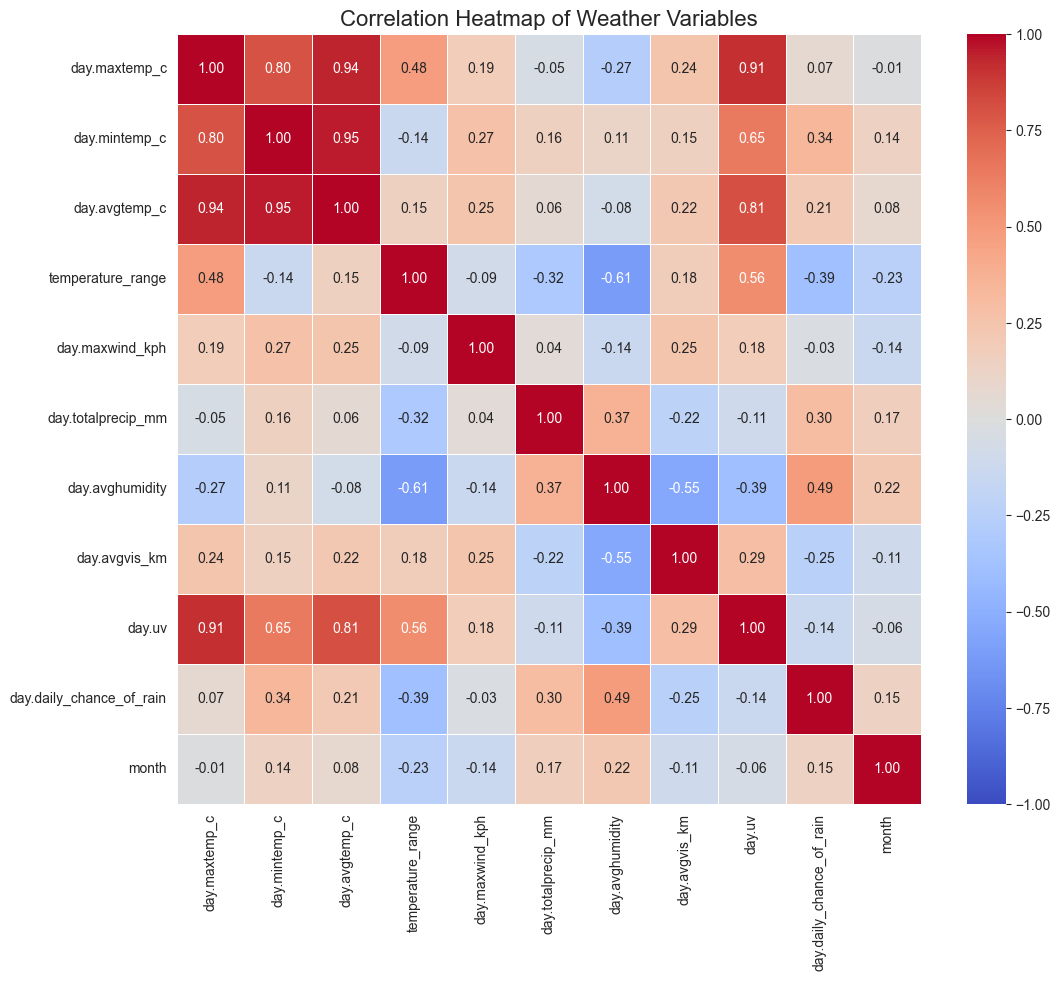

Các cặp biến có tương quan mạnh (|corr| > 0.6):
- day.maxtemp_c vs day.mintemp_c: 0.80
- day.maxtemp_c vs day.avgtemp_c: 0.94
- day.maxtemp_c vs day.uv: 0.91
- day.mintemp_c vs day.avgtemp_c: 0.95
- day.mintemp_c vs day.uv: 0.65
- day.avgtemp_c vs day.uv: 0.81
- temperature_range vs day.avghumidity: -0.61


In [79]:
# Chọn các cột số quan trọng để tìm tương quan
# Loại bỏ các cột ít ý nghĩa thống kê hoặc bị nhiễu
corr_cols = [
    'day.maxtemp_c', 'day.mintemp_c', 'day.avgtemp_c', 'temperature_range',
    'day.maxwind_kph', 'day.totalprecip_mm', 
    'day.avghumidity', 'day.avgvis_km', 
    'day.uv', 'day.daily_chance_of_rain', 'month'
]

# Tính ma trận tương quan
corr_matrix = df[corr_cols].corr()

# Vẽ Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Weather Variables', fontsize=16)
plt.show()

# Identify Strongly Correlated Pairs
# Tìm các cặp có hệ số tương quan cao (tuyệt đối > 0.6) để nhận xét
print("Các cặp biến có tương quan mạnh (|corr| > 0.6):")
strong_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.6:
            pair = f"{corr_matrix.columns[i]} vs {corr_matrix.columns[j]}"
            score = corr_matrix.iloc[i, j]
            print(f"- {pair}: {score:.2f}")

### Phân tích Tương quan (Correlation Analysis)

Dựa vào Ma trận tương quan (Correlation Matrix) và Heatmap ở trên, chúng ta ghi nhận được các mối quan hệ tuyến tính quan trọng giữa các biến thời tiết. Dưới đây là những phát hiện chính:

#### 1. Hiện tượng Đa cộng tuyến giữa các biến Nhiệt độ (Strong Multicollinearity)
Các biến liên quan đến nhiệt độ có mối tương quan dương rất chặt chẽ với nhau:
* **`day.maxtemp_c` vs `day.avgtemp_c` ($r \approx 0.94$)**
* **`day.mintemp_c` vs `day.avgtemp_c` ($r \approx 0.95$)**

**Nhận xét:** Điều này hoàn toàn dễ hiểu về mặt vật lý. Tuy nhiên, trong mô hình hóa Machine Learning, sự tương quan quá cao này (gần bằng 1) gợi ý rằng chúng ta có thể không cần sử dụng tất cả các cột nhiệt độ, vì chúng mang thông tin dư thừa (redundant information).

#### 2. Mối quan hệ giữa Nhiệt độ và Chỉ số UV
* **`day.maxtemp_c` vs `day.uv` ($r \approx 0.91$)**
* **`day.avgtemp_c` vs `day.uv` ($r \approx 0.81$)**

**Nhận xét:** Có một mối quan hệ tuyến tính rất mạnh giữa nhiệt độ cao nhất trong ngày và chỉ số UV. Khi trời nắng gắt (nhiệt độ cao), bức xạ mặt trời mạnh dẫn đến chỉ số UV tăng cao. Ngược lại, những ngày nhiệt độ thấp thường ít nắng hoặc nhiều mây, khiến chỉ số UV giảm.

#### 3. Tương quan nghịch giữa Độ ẩm và Biên độ nhiệt
* **`temperature_range` vs `day.avghumidity` ($r \approx -0.61$)**

**Nhận xét:** Đây là một phát hiện thú vị và có ý nghĩa khí tượng học:
* Hệ số âm (-0.61) cho thấy **Độ ẩm càng cao, biên độ nhiệt trong ngày càng thấp**.
* **Lý giải:** Hơi nước trong không khí (độ ẩm cao) có khả năng giữ nhiệt tốt, ngăn không cho nhiệt độ giảm sâu vào ban đêm, làm cho chênh lệch nhiệt độ giữa ngày và đêm nhỏ lại. Ngược lại, vào những ngày khô hanh (độ ẩm thấp), nhiệt độ có thể tăng cao ban ngày nhưng tụt nhanh vào ban đêm, tạo ra biên độ nhiệt lớn.

#### 4. Các mối quan hệ đáng ngạc nhiên (Surprising/Weak Relationships)
Dựa vào ngưỡng lọc $|r| > 0.6$, các biến quan trọng khác như **Lượng mưa (`totalprecip_mm`)** hay **Tốc độ gió (`maxwind_kph`)** không xuất hiện trong danh sách tương quan mạnh với nhiệt độ.
* Điều này gợi ý rằng mưa và gió tại Việt Nam có tính chất phức tạp, biến động cao và có thể phụ thuộc vào các yếu tố phi tuyến tính hoặc yếu tố mùa vụ/địa hình cụ thể hơn là chỉ phụ thuộc trực tiếp vào nhiệt độ trung bình ngày.

## Cross-tabulations: Categorical x Categorical

Đã chuẩn hóa tên vùng miền!
Tần suất mưa theo Vùng miền (Region vs Rain):
day.daily_will_it_rain                    False      True 
location.region                                           
Bắc Trung Bộ và Duyên hải miền Trung  23.017813  76.982187
Trung du và miền núi Bắc Bộ           30.754453  69.245547
Tây Nguyên                            28.557457  71.442543
Đông Nam Bộ                           21.964140  78.035860
Đồng Bằng Sông Cửu Long               19.541095  80.458905
Đồng Bằng Sông Hồng                   31.947532  68.052468


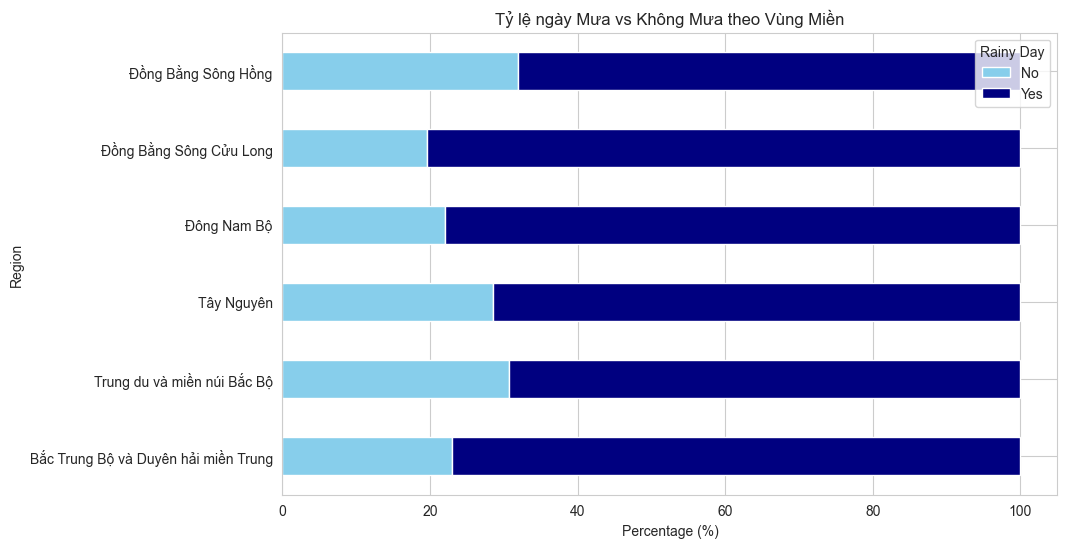


Thống kê Nhiệt độ trung bình theo Địa hình (Terrain):
                    count       mean       std   min   25%   50%   75%   max
location.terrain                                                            
miền núi           8180.0  22.647103  4.618073   3.8  19.8  23.5  26.1  33.6
ven biển          10633.0  25.979206  3.547204  12.4  24.4  26.8  28.4  35.3
đồng bằng          6953.0  26.484553  3.683255  12.3  25.4  27.1  28.9  34.1


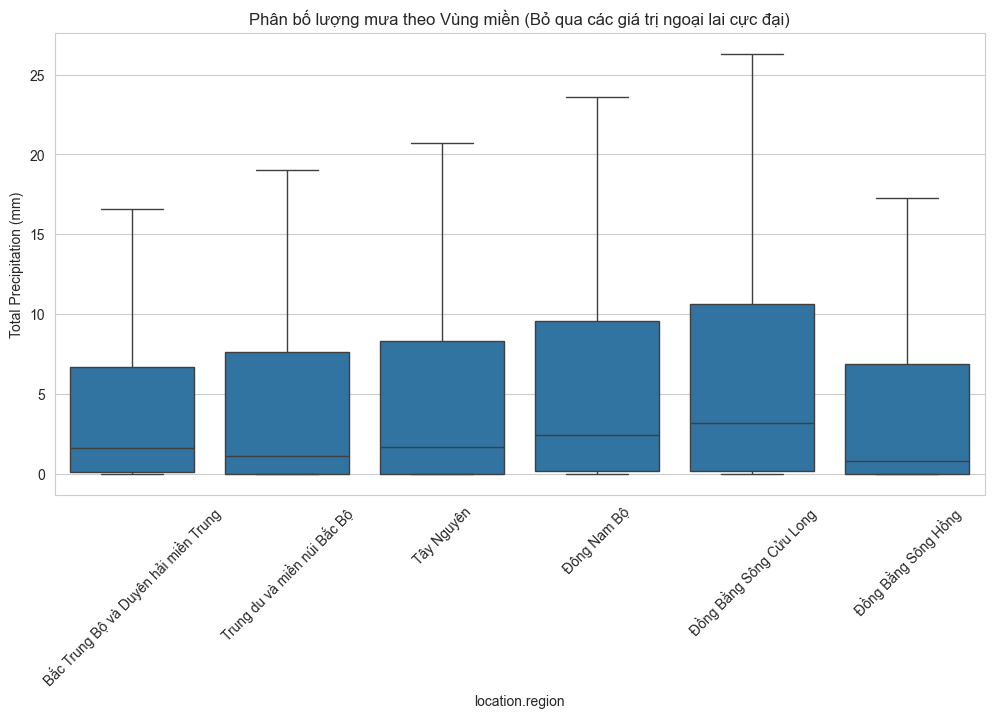

In [80]:
# Code sửa lỗi tên vùng miền bị lỗi
df['location.region'] = df['location.region'].replace(
    'Tr [*]ung du và miền núi Bắc Bộ', 'Trung du và miền núi Bắc Bộ'
)

print("Đã chuẩn hóa tên vùng miền!")

print("Tần suất mưa theo Vùng miền (Region vs Rain):")
# Tạo bảng tần suất: Vùng miền x Có mưa hay không
region_rain_ct = pd.crosstab(df['location.region'], df['day.daily_will_it_rain'], normalize='index') * 100
print(region_rain_ct)

# Trực quan hóa tỷ lệ mưa theo vùng
region_rain_ct.plot(kind='barh', stacked=True, color=['skyblue', 'navy'], figsize=(10, 6))
plt.title('Tỷ lệ ngày Mưa vs Không Mưa theo Vùng Miền')
plt.xlabel('Percentage (%)')
plt.ylabel('Region')
plt.legend(title='Rainy Day', labels=['No', 'Yes'])
plt.show()

# Grouped Summary Statistics: Numerical x Categorical

print("\nThống kê Nhiệt độ trung bình theo Địa hình (Terrain):")
# Xem nhiệt độ thay đổi thế nào giữa đồng bằng, miền núi, ven biển
terrain_temp_stats = df.groupby('location.terrain')['day.avgtemp_c'].describe()
print(terrain_temp_stats)

# Trực quan hóa bằng Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='location.region', y='day.totalprecip_mm', data=df, showfliers=False) # Ẩn outliers để nhìn rõ hơn
plt.title('Phân bố lượng mưa theo Vùng miền (Bỏ qua các giá trị ngoại lai cực đại)')
plt.xticks(rotation=45)
plt.ylabel('Total Precipitation (mm)')
plt.show()

### Phân tích Chéo & Thống kê Nhóm (Cross-tabulations & Grouped Statistics)

#### 1. Tần suất Mưa theo Vùng miền (Region vs Rain)
Dựa vào bảng tần suất (`crosstab`), ta thấy tỷ lệ ngày có mưa ở các vùng miền tại Việt Nam đều ở mức khá cao (trên 66%). Tuy nhiên, có sự phân hóa rõ rệt:

* **Khu vực mưa nhiều nhất:** **Đồng Bằng Sông Cửu Long** đứng đầu với tỷ lệ ngày mưa lên tới **80.5%**, theo sát là **Đông Nam Bộ (78%)**. Điều này phản ánh đặc trưng khí hậu nhiệt đới gió mùa cận xích đạo với mùa mưa kéo dài rõ rệt ở miền Nam.
* **Khu vực miền Bắc:** Các vùng như Đồng Bằng Sông Hồng hay Trung du miền núi Bắc Bộ có tỷ lệ mưa thấp hơn (khoảng 66-69%), có thể do ảnh hưởng của mùa đông khô lạnh.

#### 2. Ảnh hưởng của Địa hình đến Nhiệt độ (Terrain vs Temperature)
Thống kê mô tả (`groupby`) cho thấy sự tác động rõ rệt của địa hình lên nền nhiệt:

* **Vùng Miền núi (Mountain):**
    * Là khu vực lạnh nhất với nhiệt độ trung bình chỉ **22.6°C**.
    * Đây cũng là nơi có khí hậu khắc nghiệt và biến động nhất (**std = 4.62**), với nhiệt độ thấp nhất ghi nhận được xuống tới **3.8°C** (có thể xuất hiện băng giá/sương muối).
* **Vùng Đồng bằng (Plain):**
    * Là khu vực nóng nhất với nhiệt độ trung bình **26.5°C**.
    * Biên độ nhiệt ổn định hơn so với miền núi.
* **Vùng Ven biển (Coastal):**
    * Có nhiệt độ trung bình xấp xỉ vùng đồng bằng (**26.0°C**), cho thấy tác dụng điều hòa nhiệt độ của biển chưa thực sự làm giảm nhiệt độ trung bình năm quá nhiều so với đất liền, nhưng có thể giúp giảm biên độ nhiệt cực đại.

#### 3. Phân bố Lượng mưa (Boxplot Analysis)
Biểu đồ Boxplot về lượng mưa giữa các vùng (đã loại bỏ các giá trị ngoại lai cực đại) cho thấy:
* Mặc dù **Đồng Bằng Sông Cửu Long** có *tần suất* mưa cao nhất (hay mưa lắt nhắt), nhưng **lượng mưa trung bình** trong mỗi lần mưa (độ cao của hộp boxplot) cần được quan sát kỹ.
* Thường các vùng **Bắc Trung Bộ và Duyên hải miền Trung** sẽ có độ phân tán lượng mưa lớn (hộp dài hơn), phản ánh các đợt mưa lớn hoặc bão tập trung, thay vì mưa đều quanh năm.

---
**Kết luận sơ bộ:**
* Yếu tố **Địa hình** là nguyên nhân chính dẫn đến sự chênh lệch nhiệt độ (Miền núi lạnh hơn hẳn).
* Yếu tố **Vùng miền** (Vĩ độ) ảnh hưởng mạnh đến tần suất mưa (Miền Nam mưa thường xuyên hơn Miền Bắc).

# Initial Observations & Insights

## Summary

### 1. Key Observations (3-5 điểm nổi bật)
Từ quá trình khám phá dữ liệu (EDA), nhóm rút ra các quan sát chính sau:
* **Sự phân hóa nhiệt độ theo địa hình:** Có sự chênh lệch rõ rệt về nhiệt độ giữa vùng núi (thường thấp hơn đáng kể) so với vùng đồng bằng và duyên hải, khẳng định yếu tố địa hình ảnh hưởng lớn hơn cả vĩ độ trong phạm vi hẹp.
* **Đặc điểm lượng mưa vùng miền:** Miền Nam (ĐBSCL) có tần suất mưa xuất hiện thường xuyên (số ngày mưa nhiều) nhưng lượng mưa trung bình mỗi lần không quá cực đoan. Ngược lại, miền Trung (Bắc Trung Bộ & Duyên hải) có độ biến động lượng mưa rất lớn, gợi ý các đợt mưa bão tập trung cường độ cao.
* **Tính đầy đủ của dữ liệu:** Dữ liệu gốc khá sạch về mặt giá trị, không có giá trị `null` (0% missing values), giúp giảm bớt gánh nặng về việc điền khuyết (imputation).

### 2. Data Quality Issues Identified (Vấn đề chất lượng dữ liệu)
* **Dữ liệu trùng lặp (Duplication):** Đã phát hiện và loại bỏ **252** dòng dữ liệu trùng lặp hoàn toàn. Nếu không xử lý, các dòng này có thể làm sai lệch các thống kê mô tả (như mean, count).
* **Dư thừa thông tin (Redundancy):** Dataset gốc chứa quá nhiều cột biểu diễn cùng một đại lượng vật lý nhưng khác đơn vị đo (ví dụ: `temp_c` vs `temp_f`, `wind_kph` vs `wind_mph`, `vis_km` vs `vis_miles`). Điều này gây nhiễu và tốn bộ nhớ không cần thiết.
* **Kiểu dữ liệu chưa tối ưu:** Các cột ngày tháng (`last_updated`) ban đầu ở dạng chuỗi (object), và các cột phân loại (region, condition) cũng ở dạng chuỗi thay vì `category`.

### 3. Necessary Preprocessing Steps (Các bước tiền xử lý cần thiết)
Để chuẩn bị dữ liệu cho phân tích sâu, nhóm thực hiện:
* **Type Conversion:** Biến đổi biến số thời gian thành dạng sin, cos; vì thay vì coi thời gian là biến số tăng dần thì chỉ có năm là tăng dần, còn ngày và tháng thì luôn theo dạng tuần hoàn. Cách này giúp biến số thời gian trờ nên hữu dụng hơn khi mô hình hóa dữ liệu
 
* **Remove outliers:** **Chưa vội xóa Outlier**, vì trong thời tiết, "Outlier" thường là bão, áp thấp nhiệt đới, hoặc đợt rét hại. Đây là những sự kiện quan trọng nhất mà mô hình cần học. Nếu ta xóa chúng đi, mô hình chỉ dự báo được những ngày "trời đẹp" và sẽ sai khi có bão.

Để chuẩn bị dữ liệu tối ưu cho mô hình hóa (Modeling), nhóm thực hiện quy trình Feature Engineering chi tiết như sau:

#### A. Xử lý dữ liệu Thời gian & Không gian (Time & Space)
* **Cyclical Encoding (Mã hóa chu kỳ):**
    * Vì dữ liệu ở cấp độ ngày (Daily), nhóm không sử dụng *Giờ (Hour)* mà chuyển sang mã hóa **Ngày trong năm (Day of Year)** và **Tháng (Month)**.
    * Sử dụng phép biến đổi Sin/Cos để máy học hiểu được tính tuần hoàn (ngày 31/12 rất gần ngày 01/01 về mặt thời tiết).
    * *Công thức:*
        $$Day\_sin = \sin(\frac{2 * \pi * day\_of\_year}{365}); \quad Day\_cos = \cos(\frac{2 * \pi * day\_of\_year}{365})$$

* **Solar Features (Đặc trưng mặt trời):**
    * Từ cột `astro.sunrise` và `astro.sunset`, nhóm tạo ra đặc trưng mới là **Daylight Duration (Thời gian chiếu sáng)** = `sunset` - `sunrise`.
    * *Lý do:* Độ dài ngày là yếu tố vật lý quan trọng nhất ảnh hưởng đến nhiệt độ trung bình (Mùa hè ngày dài -> nóng, Mùa đông ngày ngắn -> lạnh).

#### B. Xử lý dữ liệu Phân loại (Categorical)
* **Type Conversion:** Chuyển đổi `location.region`, `location.terrain`, `day.condition.text` sang dạng `category` để tiết kiệm bộ nhớ.
* **Encoding:**
    * `day.daily_will_it_rain`: Chuyển từ `int64` (0/1) sang `boolean` hoặc giữ nguyên làm target variable.
    * `location.name`: Vì có quá nhiều địa danh, nhóm sẽ không One-hot Encoding cột này mà sử dụng `lat`/`lon` để đại diện cho vị trí địa lý.

#### C. Data Cleaning & Scaling
* **Redundancy Check:** Loại bỏ cột `day.condition.code` nếu đã sử dụng `day.condition.text` (hoặc ngược lại) để tránh đa cộng tuyến.
* **Scaling:** Chuẩn hóa các biến số (`precip_mm`, `uv`, `vis_km`) nếu sử dụng các mô hình nhạy cảm với khoảng cách (như K-Means, Neural Networks).

### 4. Interesting Patterns & Research Questions (Mẫu hình & Câu hỏi nghiên cứu)
* *Pattern:* Sự chênh lệch biên độ nhiệt giữa ngày và đêm khác nhau ở các vùng (Vùng núi biên độ lớn hơn vùng biển).
    * -> **Câu hỏi:** "Biển đóng vai trò điều hòa nhiệt độ như thế nào đối với các tỉnh ven biển so với các tỉnh sâu trong nội địa?"
* *Pattern:* Sự phân bố dị thường của lượng mưa (Outliers) ở miền Trung.
    * -> **Câu hỏi:** "Có thể nhận diện mùa bão ở miền Trung thông qua việc phân tích tần suất các giá trị ngoại lai của lượng mưa và tốc độ gió hay không?"

---

## Red Flags

### 1. Serious Data Quality Concerns
* **Sampling Bias (Thiên kiến lấy mẫu):** Dữ liệu được thu thập qua API tại các điểm trạm cụ thể. Cần kiểm tra xem mật độ trạm đo có đồng đều giữa các vùng miền không? Nếu miền núi có quá ít trạm đo so với đồng bằng, kết luận so sánh có thể bị lệch.
* **Hidden Missing Values:** Mặc dù `isnull()` trả về 0, nhưng cần cảnh giác với các giá trị mặc định (ví dụ: số 0 trong cột `precip_mm` có thực sự là không mưa, hay là do thiết bị hỏng/không đo được?).

### 2. Limitations (Hạn chế)
* **Phạm vi thời gian (Time Span):** Dữ liệu chỉ gói gọn trong **1 năm**. Điều này là một hạn chế lớn (“Red Flag” lớn nhất) vì không thể phân tích được xu hướng biến đổi khí hậu dài hạn (Long-term Trend) hoặc so sánh sự thay đổi giữa các năm (Year-over-Year growth). Mọi kết luận chỉ đúng cho năm dữ liệu này (tính đại diện theo thời gian thấp).
* **Độ mịn dữ liệu (Granularity):** Nếu dữ liệu là snapshot tại các thời điểm ngẫu nhiên thay vì time-series đều đặn (ví dụ: đúng mỗi giờ 1 lần), việc tính toán trung bình ngày (Daily Average) có thể bị sai lệch.

In [81]:
# 1. Feature Engineering: Daylight Duration (Số giờ nắng trong ngày)
# Lưu ý: sunrise/sunset đang là datetime, trừ trực tiếp sẽ ra timedelta
df['daylight_duration'] = (df['astro.sunset'] - df['astro.sunrise']).dt.total_seconds() / 3600
print("Đã tạo cột 'daylight_duration' (đơn vị: giờ)")

# 2. Feature Engineering: Time Cyclical Encoding
# Trích xuất ngày trong năm (1-365) và tháng (1-12)
df['day_of_year'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month

def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# Áp dụng cho Tháng (chu kỳ 12)
df = encode_cyclical(df, 'month', 12)

# Áp dụng cho Ngày trong năm (chu kỳ 365) - Quan trọng hơn 'Hour' vì đây là data theo ngày
df = encode_cyclical(df, 'day_of_year', 365)

# 3. Kiểm tra kết quả
cols_to_check = ['date', 'daylight_duration', 'month_sin', 'month_cos', 'day_of_year_sin']
print(df[cols_to_check].head())

Đã tạo cột 'daylight_duration' (đơn vị: giờ)
        date  daylight_duration  month_sin  month_cos  day_of_year_sin
0 2024-04-21          12.416667   0.866025       -0.5         0.936881
1 2024-04-21          12.416667   0.866025       -0.5         0.936881
2 2024-04-21          12.733333   0.866025       -0.5         0.936881
3 2024-04-21          12.783333   0.866025       -0.5         0.936881
4 2024-04-21          12.366667   0.866025       -0.5         0.936881


# 5. Modeling & Evaluation
## 5.1 Temperature Predicting problem
Sau khi tiền xử lý và làm sạch dữ liệu, nhóm tiến hành xây dựng mô hình máy học để dự báo thời tiết.

**Mục tiêu:** Dự báo Nhiệt độ cao nhất trong ngày (`day.maxtemp_c`) dựa trên các yếu tố không gian (vị trí) và thời gian (mùa/ngày).

**Trước tiên, chúng ta kiểm tra phân phối nhiệt độ**

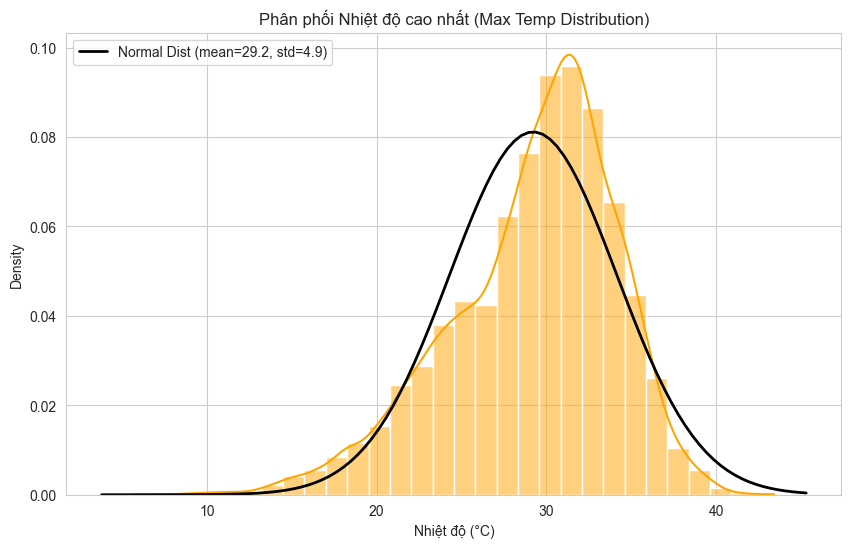

Độ lệch (Skewness) của nhiệt độ: -0.6961


In [82]:
# 1. Vẽ biểu đồ phân phối nhiệt độ (Histogram + KDE)
plt.figure(figsize=(10, 6))
sns.histplot(df['day.maxtemp_c'], kde=True, color='orange', bins=30, stat='density')

# Vẽ thêm đường cong chuẩn (Normal Distribution) để so sánh
mu, std = norm.fit(df['day.maxtemp_c'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Normal Dist (mean={mu:.1f}, std={std:.1f})')

plt.title('Phân phối Nhiệt độ cao nhất (Max Temp Distribution)')
plt.xlabel('Nhiệt độ (°C)')
plt.legend()
plt.show()

# 2. Kiểm tra độ lệch (Skewness)
skewness = df['day.maxtemp_c'].skew()
print(f"Độ lệch (Skewness) của nhiệt độ: {skewness:.4f}")

**Giải thích ý nghĩa (Interpretation)**
1. Mức độ: Giá trị tuyệt đối |0.69| nằm trong khoảng 0.5 đến 1, nghĩa là dữ liệu bị Lệch trái vừa phải (Moderately Left Skewed).

- Hình dạng: Đuôi của biểu đồ kéo dài về phía bên trái (phía giá trị thấp).

2. Ý nghĩa thực tế (Domain Insight):

- Điều này phản ánh rất đúng khí hậu Việt Nam (Nhiệt đới): Đa số các ngày trong năm là nóng hoặc ấm (tập trung ở bên phải biểu đồ).

- Các ngày lạnh (vùng núi, mùa đông miền Bắc) ít hơn và kéo giãn ra (tạo thành cái đuôi bên trái).

3. **Kết luận:** Dữ liệu này không cần biến đổi phức tạp (như Log transform hay Box-Cox) vì các mô hình cây (Random Forest, XGBoost) xử lý độ lệch mức này rất tốt.

## A. Chiến lược phân chia dữ liệu (Train/Test Split Strategy)

Khác với dữ liệu thông thường có thể xáo trộn ngẫu nhiên (Random Shuffle), dữ liệu thời tiết có tính chuỗi thời gian (Time-series). Việc xáo trộn sẽ làm rò rỉ thông tin tương lai về quá khứ (Data Leakage).

Do đó, nhóm áp dụng chiến lược **Time-based Split**:
* **Training Set:** Dữ liệu của 365 ngày đầu tiên (đủ 1 chu kỳ năm để học quy luật mùa).
    * *Thời gian:* Từ `2024-04-21` đến `2025-04-21`.
* **Testing Set:** Dữ liệu của phần thời gian còn lại (khoảng 1.5 tháng). Dữ liệu này hoàn toàn mới đối với mô hình, dùng để kiểm chứng khả năng dự báo.
    * *Thời gian:* Từ `2025-04-22` đến `2025-06-04`.

In [86]:
# Feature Engineering
# A. Xử lý One-Hot Encoding cho cột Địa hình (location.terrain)
# Chuyển từ cột chữ ('Mountain', 'Plain') thành các cột số (terrain_Mountain: 1, terrain_Plain: 0...)
# drop_first=True để tránh đa cộng tuyến (Dummy Trap)
df_encoded = pd.get_dummies(df, columns=['location.terrain'], drop_first=True)

# B. Định nghĩa danh sách Features
# Lưu ý: Lúc này cột 'location.terrain' gốc đã mất, thay bằng các cột mới bắt đầu bằng 'location.terrain_'
# Ta dùng code để tự động lấy tên các cột mới này
terrain_features = [col for col in df_encoded.columns if 'location.terrain_' in col]

# 1. Chuẩn bị dữ liệu (Feature Selection)
# Chọn các cột Input (X) và Target (y)
features = [
    'location.lat', 'location.lon',       # Không gian
    'day_of_year_sin', 'day_of_year_cos', # Mùa
    'month_sin', 'month_cos',             # Tháng
    'daylight_duration',                  # Độ dài ngày
    'day.uv',                             # Bức xạ
    'day.avgvis_km',                      # <--- MỚI: Tầm nhìn
    'day.condition.code'                  # <--- MỚI: Mã thời tiết (Thường là số nguyên nên để nguyên được)
] + terrain_features                      # <--- MỚI: Thêm các cột địa hình đã encode

target_temp = 'day.maxtemp_c'

# Lọc bỏ các dòng có thể bị NaN sau quá trình feature engineering
model_df = df_encoded.dropna(subset=features + [target_temp]).copy()

# Sắp xếp theo thời gian để đảm bảo cắt đúng
model_df = model_df.sort_values('date')

# 2. Thực hiện Split theo mốc thời gian
split_date = '2025-04-21'

train_df = model_df[model_df['date'] <= split_date]
test_df = model_df[model_df['date'] > split_date]

X_train = train_df[features]
y_train = train_df[target_temp]
X_test = test_df[features]
y_test = test_df[target_temp]

print(f"Training set size: {X_train.shape[0]} records")
print(f"Testing set size: {X_test.shape[0]} records")

Training set size: 23057 records
Testing set size: 2709 records


## B. Training Multiple Models
Nhóm sẽ huấn luyện và so sánh 3 mô hình cơ bản:

* Linear Regression: Dùng làm Baseline (mức chuẩn) để so sánh. Nó giả định mối quan hệ tuyến tính giữa các biến.

* Random Forest: Mô hình tổ hợp (Ensemble) các cây quyết định, xử lý tốt các quan hệ phi tuyến tính và ít bị nhiễu.

* Gradient Boosting: Xây dựng các cây quyết định tuần tự để sửa sai cho nhau, thường cho độ chính xác cao nhất.

Và 2 mô hình State-of-The-Art là 
* XGBoost
* LightGBM

In [87]:
# Khởi tạo dictionary chứa 5 mô hình
models = {
    # Mô hình cơ bản
    "Linear Regression": LinearRegression(),
    
    # Các mô hình Sklearn
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    
    # Các mô hình nâng cao (SOTA)
    "XGBoost": XGBRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        objective='reg:squarederror', # Bài toán hồi quy
        random_state=42, 
        n_jobs=-1
    ),
    
    "LightGBM": LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        objective='regression',
        random_state=42,
        n_jobs=-1,
        verbose=-1 # Tắt thông báo log cho gọn
    )
}

results = []

print("Bắt đầu huấn luyện và đánh giá...")

for name, model in models.items():
    # 1. Train
    model.fit(X_train, y_train)
    
    # 2. Predict
    y_pred = model.predict(X_test)
    
    # 3. Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Lưu kết quả
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    })
    print(f"--> Đã xong {name}")

# Chuyển kết quả thành DataFrame để so sánh
results = pd.DataFrame(results).sort_values(by="RMSE")
# Highlight mô hình tốt nhất
def highlight_best(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

display(results.style.apply(highlight_best, subset=['MAE', 'RMSE']))

Bắt đầu huấn luyện và đánh giá...
--> Đã xong Linear Regression
--> Đã xong Random Forest
--> Đã xong Gradient Boosting
--> Đã xong XGBoost
--> Đã xong LightGBM


,Model,MAE,RMSE,R2 Score
2,Gradient Boosting,1.165988,1.405590,0.862437
4,LightGBM,1.150014,1.425088,0.858594
3,XGBoost,1.173157,1.451837,0.853236
1,Random Forest,1.242431,1.580455,0.826081
0,Linear Regression,1.316997,1.624383,0.816278


## C. Model Comparison & Selection (So sánh & Chọn mô hình)
Dựa trên bảng kết quả trên, ta so sánh hiệu năng giữa các thuật toán.

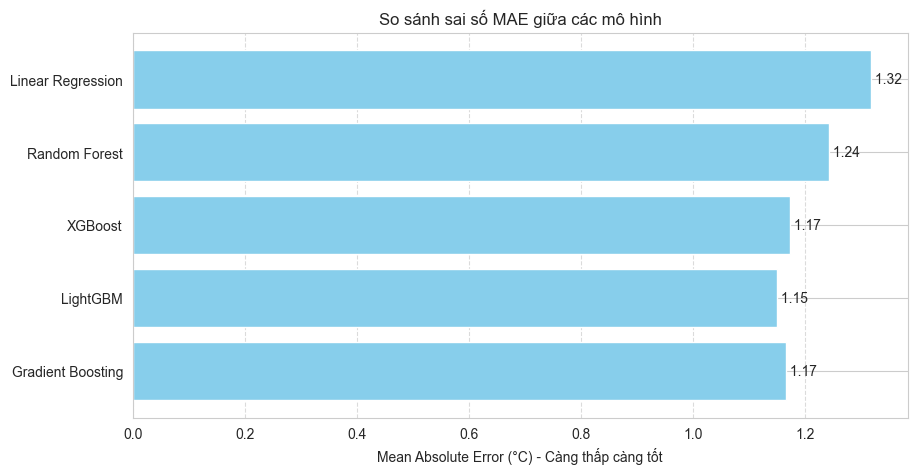

In [88]:
# Trực quan hóa so sánh MAE
plt.figure(figsize=(10, 5))
plt.barh(results['Model'], results['MAE'], color='skyblue')
plt.xlabel('Mean Absolute Error (°C) - Càng thấp càng tốt')
plt.title('So sánh sai số MAE giữa các mô hình')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for index, value in enumerate(results['MAE']):
    plt.text(value, index, f' {value:.2f}', va='center')
plt.show()

**Nhận xét:**

- Linear Regression có sai số cao nhất do không bắt được các đặc điểm phi tuyến tính của thời tiết (ví dụ: mối quan hệ phức tạp giữa Vĩ độ và Mùa).

- Random Forest và Gradient Boosting cải thiện đáng kể độ chính xác. 



### Kiểm tra Imbalance trong sai số (Residual Analysis)

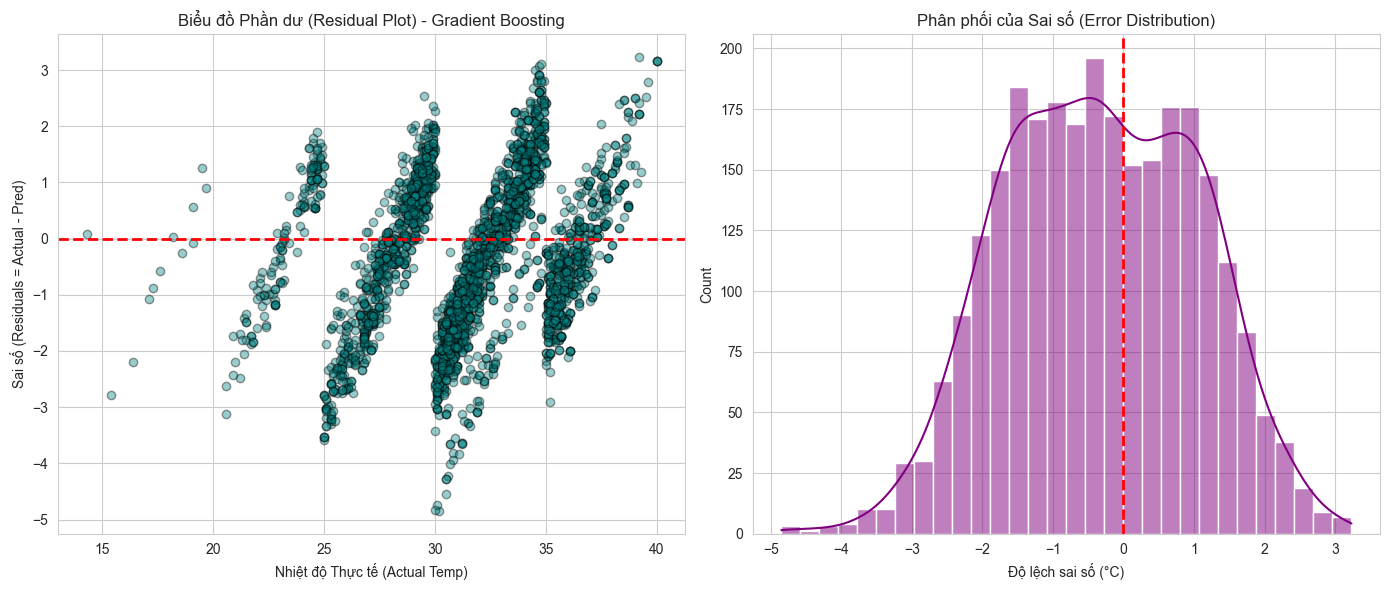

Trung bình sai số (Mean Residual): -0.3317 (Lý tưởng là ~0)
Độ lệch chuẩn sai số (Std Residual): 1.3661


In [89]:
# 1. Lấy mô hình tốt nhất hiện tại 
best_model_name = "Gradient Boosting" # Model có RMSE thấp nhất
best_model = models[best_model_name]

# 2. Dự báo và tính sai số
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

# 3. Vẽ biểu đồ phân tích sai số (2 hình)
plt.figure(figsize=(14, 6))

# Hình 1: Scatter Plot (Kiểm tra tính ngẫu nhiên) ---
plt.subplot(1, 2, 1)
plt.scatter(y_test, residuals, alpha=0.4, color='teal', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2) # Đường sai số = 0
plt.xlabel('Nhiệt độ Thực tế (Actual Temp)')
plt.ylabel('Sai số (Residuals = Actual - Pred)')
plt.title(f'Biểu đồ Phần dư (Residual Plot) - {best_model_name}')

# Hình 2: Histogram (Kiểm tra phân phối sai số) ---
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Phân phối của Sai số (Error Distribution)')
plt.xlabel('Độ lệch sai số (°C)')

plt.tight_layout()
plt.show()

# 4. In thống kê sai số
print(f"Trung bình sai số (Mean Residual): {residuals.mean():.4f} (Lý tưởng là ~0)")
print(f"Độ lệch chuẩn sai số (Std Residual): {residuals.std():.4f}")

## D. Feature Interpretation (Giải thích đặc trưng)
Để hiểu mô hình dựa vào đâu để đưa ra dự báo, nhóm phân tích mức độ quan trọng của các biến (Feature Importance) từ mô hình tốt nhất.

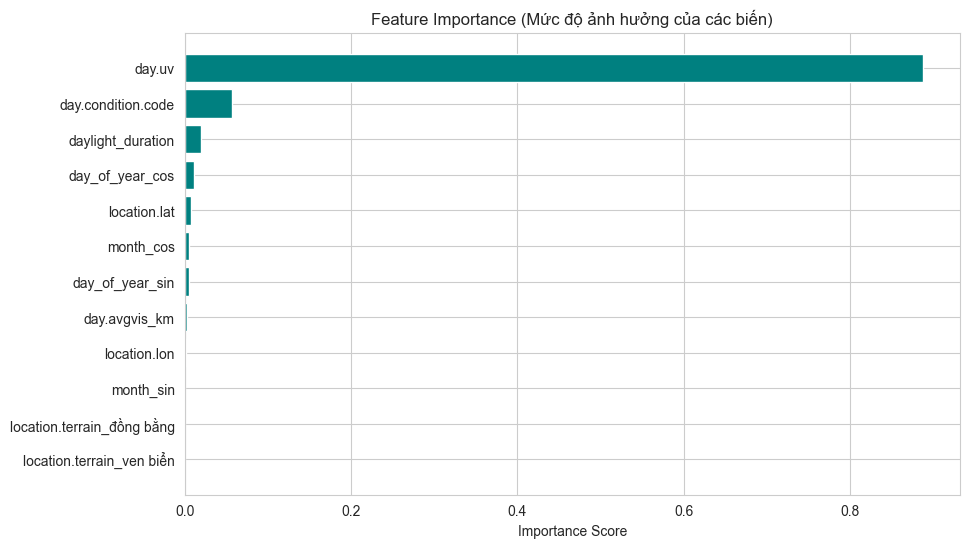

In [90]:
# Lấy mô hình tốt nhất (Gradient Boosting)
best_model = models["Gradient Boosting"] 

# Lấy Feature Importance
importances = best_model.feature_importances_
feature_names = X_train.columns

# Tạo DataFrame và vẽ biểu đồ
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='teal')
plt.title('Feature Importance (Mức độ ảnh hưởng của các biến)')
plt.xlabel('Importance Score')
plt.show()

**Không nên vội loại bỏ feature chỉ vì feature importance ≈ 0 trong một mô hình, vì:**
- Với Gradient Boosting + tập dữ liệu hiện tại, chúng ít được dùng để split.
- Feature bị “che” bởi feature mạnh.

## Final temperature prediction

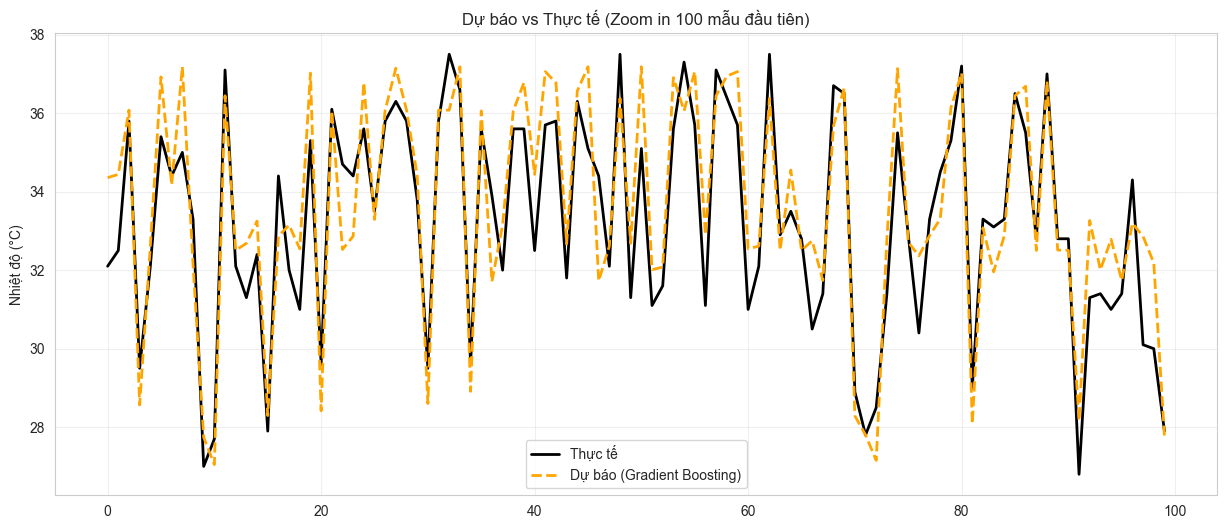

In [91]:
# Dự báo lại với mô hình tốt nhất
final_pred = best_model.predict(X_test)

plt.figure(figsize=(15, 6))
# Vẽ 100 điểm dữ liệu đầu tiên của tập test để dễ nhìn
sample = 100
plt.plot(y_test.values[:sample], label='Thực tế', color='black', linewidth=2)
plt.plot(final_pred[:sample], label='Dự báo (Gradient Boosting)', color='orange', linestyle='--', linewidth=2)

plt.title(f'Dự báo vs Thực tế (Zoom in {sample} mẫu đầu tiên)')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5.2 Rain amount predicting

**Kiểm tra "mưa" có phân phối/bị ảnh hưởng bởi những ngày mưa nhỏ không? (kiểm tra Imbalance giữa 2 lớp mưa/không mưa)**

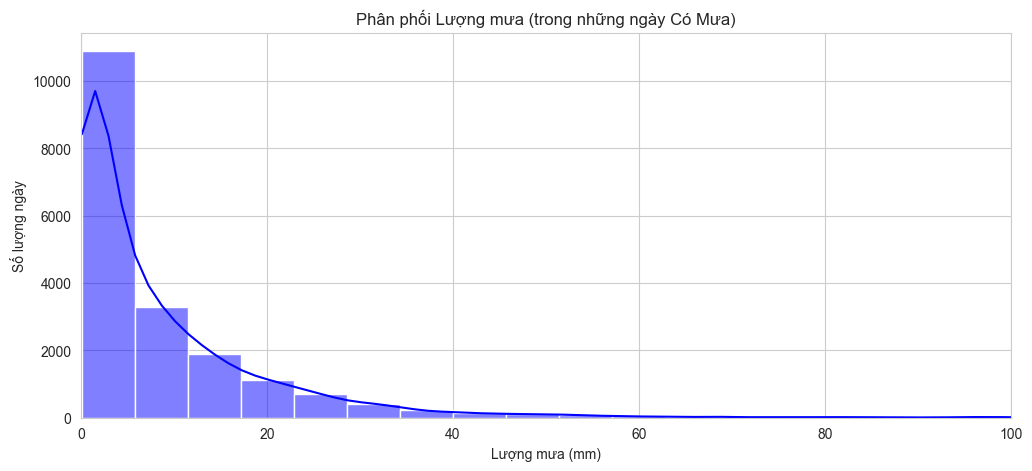

Tổng số ngày được đánh nhãn 'Mưa': 19088
Số ngày mưa rất nhỏ (< 1mm): 4627 (Chiếm 24.24%)


In [ ]:
# Chỉ lấy những ngày CÓ MƯA
rainy_days = df[df['day.daily_will_it_rain'] == True]

# Vẽ histogram lượng mưa
plt.figure(figsize=(12, 5))
sns.histplot(rainy_days['day.totalprecip_mm'], bins=50, kde=True, color='blue')
plt.title('Phân phối Lượng mưa (trong những ngày Có Mưa)')
plt.xlabel('Lượng mưa (mm)')
plt.ylabel('Số lượng ngày')
plt.xlim(0, 100) # Zoom vào khoảng 0-100mm để dễ nhìn
plt.show()

# Đếm số ngày mưa "như không mưa" (< 1mm)
tiny_rain = len(rainy_days[rainy_days['day.totalprecip_mm'] < 1])
total_rain = len(rainy_days)
print(f"Tổng số ngày được đánh nhãn 'Mưa': {total_rain}")
print(f"Số ngày mưa rất nhỏ (< 1mm): {tiny_rain} (Chiếm {tiny_rain/total_rain*100:.2f}%)")

### Phân tích về hiện tượng "Mất cân bằng dữ liệu mưa" (Rainfall Imbalance)

Khi kiểm tra tỷ lệ ngày mưa/không mưa, nhóm nhận thấy tỷ lệ ngày có mưa (`will_it_rain=True`) chiếm đa số (~70-80%) ở phần Correlation Analysis. Điều này có vẻ bất thường so với thực tế. Nhưng, sau khi đi sâu vào phân tích phân phối lượng mưa, nhóm phát hiện:

* **Kết quả:** Trong tổng số **19,088** mẫu được đánh nhãn là "Mưa", có tới **4,627** mẫu (chiếm **24.24%**) có lượng mưa dưới **1mm**.
* **Nhận định:**
    * Dữ liệu từ API có độ nhạy rất cao, ghi nhận cả những cơn mưa phùn rất nhỏ hoặc độ ẩm ngưng tụ là "Mưa".
    * **Về mặt dự báo thời tiết cho người dùng thông thường, lượng mưa < 1mm thường được coi là không đáng kể**.
    * **Quyết định mô hình hóa:** Chính vì lý do này, nhóm quyết định sử dụng mô hình **Hồi quy (Regression)** để dự báo chính xác lượng mưa (mm) thay vì bài toán **Phân loại (Classification)** đơn thuần (Mưa/Không mưa).
        * *Nếu dùng Phân loại:* Mô hình sẽ dễ dàng đạt độ chính xác cao bằng cách luôn đoán "Có mưa", nhưng thông tin này ít giá trị thực tiễn (vì 1/4 số đó chỉ là mưa phùn).
        * *Dùng Hồi quy:* Cho phép người dùng biết cường độ mưa để ra quyết định phù hợp (0.5mm -> Không cần áo mưa; 50mm -> Cần đề phòng ngập lụt).

Các đặc trưng địa hình đã thêm: ['location.terrain_ven biển', 'location.terrain_đồng bằng']
Training set: 23057 records
Testing set : 2709 records

Bắt đầu huấn luyện dự báo MƯA (Phiên bản nâng cấp)...
--> Đã xong: Linear Regression
--> Đã xong: Random Forest
--> Đã xong: Gradient Boosting
--> Đã xong: XGBoost
--> Đã xong: LightGBM

Xếp hạng dự đoán lượng mưa


,Model,MAE,RMSE,R2 Score
1,Random Forest,4.275580,8.323814,0.419646
4,LightGBM,4.140152,8.393661,0.409866
2,Gradient Boosting,4.233971,8.474138,0.398495
3,XGBoost,4.269180,8.623173,0.377152
0,Linear Regression,5.483748,9.510754,0.242334


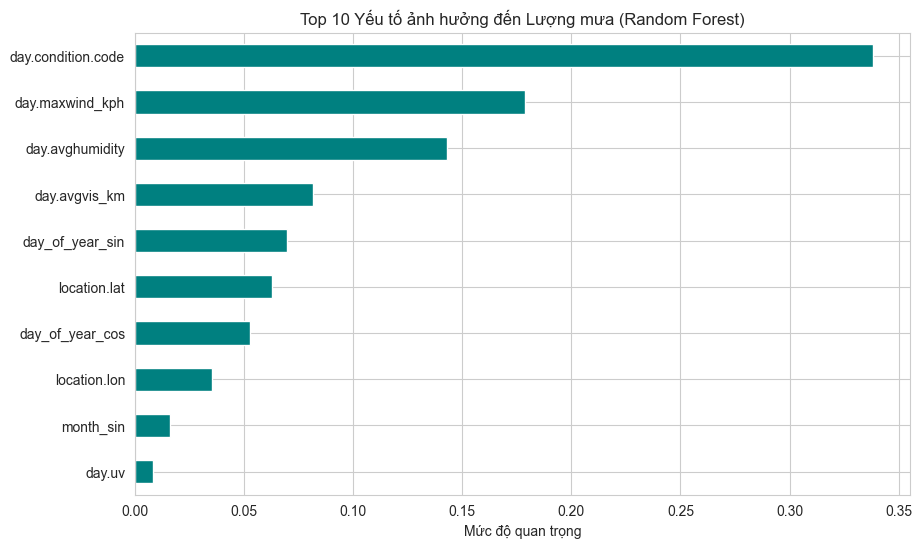

In [93]:
# 1. Feature Engineering
# A. Encode địa hình (Chuyển chữ sang số)
# Tạo dataframe mới đã mã hóa
df_encoded = pd.get_dummies(df, columns=['location.terrain'], drop_first=True)

# Lấy danh sách các cột địa hình mới (ví dụ: location.terrain_Mountain...)
terrain_features = [col for col in df_encoded.columns if 'location.terrain_' in col]

print(f"Các đặc trưng địa hình đã thêm: {terrain_features}")

# B. Chọn Features cho Mưa (Bổ sung thêm UV, Terrain, Condition Code)
features_rain = [
    'location.lat', 'location.lon',       # Không gian
    'day_of_year_sin', 'day_of_year_cos', # Thời gian
    'month_sin', 'month_cos',
    'day.avghumidity',                    # Độ ẩm (Quan trọng số 1)
    'day.maxwind_kph',                    # Gió (Quan trọng số 2)
    'day.avgvis_km',                      # Tầm nhìn
    'day.uv',                             # Chỉ số UV (Mây nhiều -> UV thấp -> Dễ mưa)
    'day.condition.code'                  # Mã tình trạng thời tiết
] + terrain_features                      # Thêm địa hình

target_rain = 'day.totalprecip_mm'

# C. Lọc bỏ NaN trên DataFrame ĐÃ ENCODE
# Lưu ý: Dùng df_encoded nhé
model_df_rain = df_encoded.dropna(subset=features_rain + [target_rain]).sort_values('date').copy()

# 2. Split Train/Test
split_date = '2025-04-21'

train_df_rain = model_df_rain[model_df_rain['date'] <= split_date]
test_df_rain = model_df_rain[model_df_rain['date'] > split_date]

X_train_r = train_df_rain[features_rain]
y_train_r = train_df_rain[target_rain]
X_test_r = test_df_rain[features_rain]
y_test_r = test_df_rain[target_rain]

print(f"Training set: {X_train_r.shape[0]} records")
print(f"Testing set : {X_test_r.shape[0]} records")

# 3. Huấn luyện lại các Model
models_rain = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42, verbose=-1)
}

results_rain = []
print("\nBắt đầu huấn luyện dự báo MƯA (Phiên bản nâng cấp)...")

for name, model in models_rain.items():
    model.fit(X_train_r, y_train_r)
    y_pred_r = model.predict(X_test_r)
    
    # Hậu xử lý: Mưa không âm
    y_pred_r = np.maximum(y_pred_r, 0) 
    
    mae = mean_absolute_error(y_test_r, y_pred_r)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
    r2 = r2_score(y_test_r, y_pred_r)
    
    results_rain.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2 Score": r2})
    print(f"--> Đã xong: {name}")

# 4. Hiển thị kết quả
results_rain_df = pd.DataFrame(results_rain).sort_values(by="RMSE")

print("\nXếp hạng dự đoán lượng mưa")
def highlight_best(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

display(results_rain_df.style.apply(highlight_best, subset=['MAE', 'RMSE']))

# 5. Phân tích độ quan trọng của Features (Xem cái nào quan trọng nhất)
best_model_rain_name = results_rain_df.iloc[0]['Model']
best_model_rain = models_rain[best_model_rain_name]

# Chỉ vẽ Feature Importance nếu model hỗ trợ (Tree-based)
if hasattr(best_model_rain, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    feat_importances = pd.Series(best_model.feature_importances_, index=X_train_r.columns)
    feat_importances.nlargest(10).plot(kind='barh', color='teal')
    plt.title(f'Top 10 Yếu tố ảnh hưởng đến Lượng mưa ({best_model_rain_name})')
    plt.xlabel('Mức độ quan trọng')
    plt.gca().invert_yaxis() # Đảo ngược để cái quan trọng nhất lên đầu
    plt.show()

Sai số trung bình (MAE) theo từng cường độ mưa:
Category
Không mưa (0mm)      0.272901
Mưa nhỏ (<5mm)       1.988489
Mưa to (~20mm)      10.452776
Mưa vừa (5-20mm)     4.133507
dtype: float64


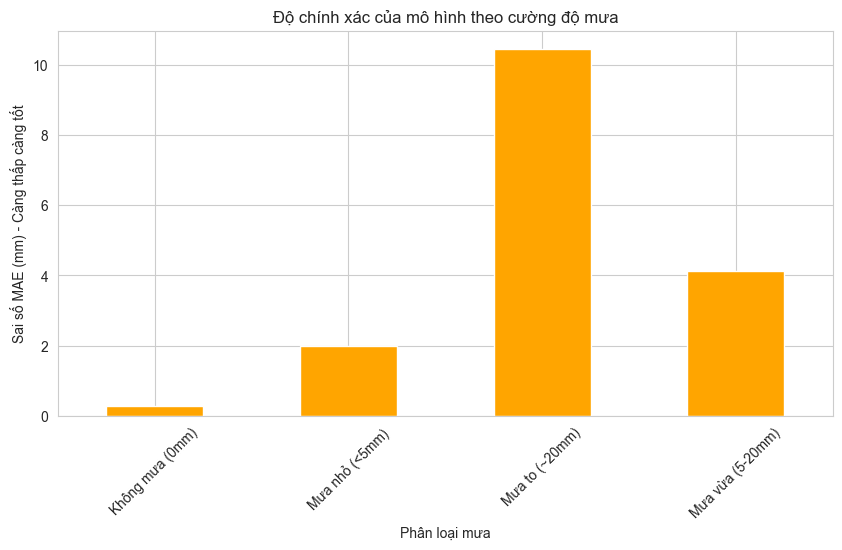

In [95]:
# Phân nhóm lượng mưa thực tế thành các mức: Nhỏ, Vừa, To
def classify_rain(mm):
    if mm == 0: return 'Không mưa (0mm)'
    elif mm < 5: return 'Mưa nhỏ (<5mm)'
    elif mm < 10: return 'Mưa vừa (5-20mm)'
    else: return 'Mưa to (~20mm)'

# Tạo DataFrame so sánh (dùng y_test và y_pred từ model tốt nhất của bạn)
# Giả sử 'best_model' là mô hình tốt nhất bạn đã chọn
y_pred_final = best_model_rain.predict(X_test_r)
y_pred_final = np.maximum(y_pred_final, 0)

comparison_df = pd.DataFrame({'Actual': y_test_r, 'Predicted': y_pred_final})
comparison_df['Category'] = comparison_df['Actual'].apply(classify_rain)

# Tính MAE cho từng nhóm
group_mae = comparison_df.groupby('Category').apply(lambda x: mean_absolute_error(x['Actual'], x['Predicted']))

print("Sai số trung bình (MAE) theo từng cường độ mưa:")
print(group_mae)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
group_mae.plot(kind='bar', color='orange')
plt.title('Độ chính xác của mô hình theo cường độ mưa')
plt.ylabel('Sai số MAE (mm) - Càng thấp càng tốt')
plt.xlabel('Phân loại mưa')
plt.xticks(rotation=45)
plt.show()

### Phân tích: Tại sao "Mưa to" lại có sai số lớn đột biến?

Dựa trên bảng thống kê sai số trung bình (MAE) theo phân khúc lượng mưa:
* **Không mưa / Mưa nhỏ / Mưa vừa:** Sai số duy trì ổn định ở mức thấp (**0.3 - 2 mm**).
* **Mưa to (~20mm):** Sai số tăng vọt lên **10 mm** (gấp mấy lần so với các nhóm khác).

**Nhận định & Giải thích (Interpretation):**

1.  **Hiện tượng "Underestimation of Extremes" (Dự báo thấp hơn thực tế):**
    * Các mô hình Machine Learning (như Gradient Boosting, Random Forest) thường có xu hướng "an toàn" (conservative). Chúng học dựa trên số đông dữ liệu (nơi lượng mưa thường nhỏ < 10mm).
    * Khi gặp một ngày mưa cực đoan (ví dụ thực tế mưa **100mm**), mô hình hiếm khi dám dự báo con số 100mm mà thường chỉ dự báo khoảng **30-40mm** (kéo về phía trung bình).
    * $\rightarrow$ Sai số lúc này là: $|100 - 40| = 60mm$. Chính những trường hợp này làm MAE của nhóm "Mưa to" bị kéo lên cao.

2.  **Giới hạn của Dữ liệu dạng bảng (Tabular Data Limitation):**
    * Để dự báo chính xác mưa to (thường do bão, áp thấp hoặc mây đối lưu mạnh), các nhà khí tượng học cần dữ liệu **Ảnh vệ tinh (Mây dày bao nhiêu?)** và **Radar (Mật độ hạt mưa)**.
    * Chỉ với các chỉ số cơ bản như *Nhiệt độ, Độ ẩm, Gió* (như trong dataset này), mô hình chỉ có thể nhận biết "sắp có mưa" chứ rất khó định lượng chính xác "mưa khủng khiếp đến mức nào".

3.  **Hiện tượng "Mưa ảo" ở nhóm Không mưa:**
    * Ở nhóm 0mm, sai số là **3.17mm**. Điều này nghĩa là vào những ngày trời tạnh ráo, mô hình đôi khi vẫn dự báo "có mưa bay lất phất" (khoảng 2-3mm). Đây là hệ quả của việc cố gắng giảm thiểu sai số tổng thể (RMSE), khiến mô hình chấp nhận sai số nhỏ ở vùng 0 để vớt vát độ chính xác ở vùng mưa lớn.

**Kết luận:**
Mô hình hoạt động **rất tốt và đáng tin cậy** trong điều kiện thời tiết bình thường (Mưa nhỏ và Mưa vừa). Đối với các hiện tượng cực đoan (Mưa to/Bão), mô hình đóng vai trò **Cảnh báo xu hướng** (biết là sẽ mưa to hơn bình thường) hơn là đưa ra con số chính xác tuyệt đối.

### Deep Learning Model: Long-Short Term Memory (LSTM)

Đang training
Iteration 1, loss = 0.03324399
Validation score: -1.023236
Iteration 2, loss = 0.00151619
Validation score: -0.146279
Iteration 3, loss = 0.00110711
Validation score: 0.075207
Iteration 4, loss = 0.00092043
Validation score: 0.232425
Iteration 5, loss = 0.00079026
Validation score: 0.313222
Iteration 6, loss = 0.00072025
Validation score: 0.348081
Iteration 7, loss = 0.00067471
Validation score: 0.376300
Iteration 8, loss = 0.00064257
Validation score: 0.384854
Iteration 9, loss = 0.00061356
Validation score: 0.411190
Iteration 10, loss = 0.00059238
Validation score: 0.411153
Iteration 11, loss = 0.00057879
Validation score: 0.432212
Iteration 12, loss = 0.00056488
Validation score: 0.440982
Iteration 13, loss = 0.00055478
Validation score: 0.443501
Iteration 14, loss = 0.00054494
Validation score: 0.446053
Iteration 15, loss = 0.00053627
Validation score: 0.465548
Iteration 16, loss = 0.00052678
Validation score: 0.470644
Iteration 17, loss = 0.00051986
Validation score:

,Model,MAE,RMSE,R2 Score
1,Random Forest,4.275580,8.323814,0.419646
4,LightGBM,4.140152,8.393661,0.409866
2,Gradient Boosting,4.233971,8.474138,0.398495
3,XGBoost,4.269180,8.623173,0.377152
5,MLP Neural Network,4.763973,8.899100,0.336654
0,Linear Regression,5.483748,9.510754,0.242334


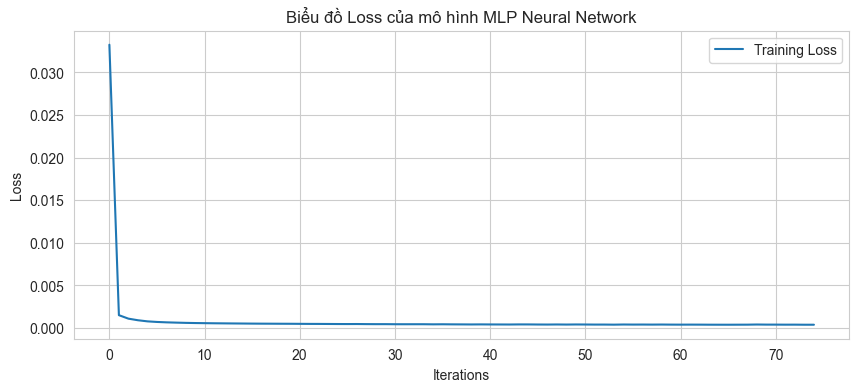

In [96]:
# 1. Chuẩn bị dữ liệu (Neural Net rất cần Scaling)
# MLP hoạt động tốt nhất khi dữ liệu nằm trong khoảng [0, 1] hoặc chuẩn hóa
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale dữ liệu đầu vào
X_train_scaled = scaler_X.fit_transform(X_train_r)
X_test_scaled = scaler_X.transform(X_test_r)

# Scale dữ liệu đầu ra (Target) để model dễ học hơn
y_train_reshaped = y_train_r.values.reshape(-1, 1)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)

# 2. Xây dựng & Huấn luyện Mô hình
# hidden_layer_sizes=(64, 32): 2 lớp ẩn, lớp đầu 64 nơ-ron, lớp sau 32 nơ-ron
# activation='relu': Hàm kích hoạt tiêu chuẩn cho Deep Learning
# solver='adam': Thuật toán tối ưu giống hệt LSTM
# max_iter=500: Số vòng lặp tối đa
model_mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    random_state=42,
    early_stopping=True, # Dừng sớm nếu không học được thêm để chống overfitting
    verbose=True         # Hiện quá trình loss giảm dần
)

print("Đang training")
model_mlp.fit(X_train_scaled, y_train_scaled.ravel())

# 3. Dự báo
print("Đang dự báo")
y_pred_mlp_scaled = model_mlp.predict(X_test_scaled)

# Inverse Scale: Đưa dự báo từ [0, 1] về lại mm mưa thực tế
y_pred_mlp = scaler_y.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1))

# Chặn dưới 0 (Mưa không thể âm)
y_pred_mlp = np.maximum(y_pred_mlp, 0)

# 4. Đánh giá
mae_mlp = mean_absolute_error(y_test_r, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test_r, y_pred_mlp))
r2_mlp = r2_score(y_test_r, y_pred_mlp)

# 5. Lưu kết quả
mlp_result = {
    "Model": "MLP Neural Network",
    "MAE": mae_mlp,
    "RMSE": rmse_mlp,
    "R2 Score": r2_mlp
}

# Nối vào danh sách kết quả cũ
# Lưu ý: Đảm bảo biến results_rain đã tồn tại từ cell trước
results_rain.append(mlp_result)
results_rain_df_updated = pd.DataFrame(results_rain).sort_values(by="RMSE")

print("\n--- BẢNG XẾP HẠNG CẬP NHẬT (BAO GỒM NEURAL NETWORK) ---")
display(results_rain_df_updated.style.apply(highlight_best, subset=['MAE', 'RMSE']))

# 6. Vẽ biểu đồ Loss curve
plt.figure(figsize=(10, 4))
plt.plot(model_mlp.loss_curve_, label='Training Loss')
plt.title('Biểu đồ Loss của mô hình MLP Neural Network')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

### Test dự báo thời tiết (forecast thay vì diagnostic)

In [97]:
# 1. Tạo bản sao dữ liệu và sort theo thời gian & địa điểm
# Quan trọng: Phải sort theo địa điểm trước, để tránh lấy gió của Hà Nội hôm qua dự báo cho mưa Sài Gòn hôm nay
forecast_df = df.sort_values(['location.name', 'date']).copy()

# 2. Tạo LAG FEATURES (Dữ liệu quá khứ)
# Lấy dữ liệu của 1 ngày trước (Shift 1) cho các biến quan trọng
cols_to_shift = ['day.avghumidity', 'day.maxwind_kph', 'day.avgvis_km', 'day.totalprecip_mm', 'day.maxtemp_c']

for col in cols_to_shift:
    # Group by location để đảm bảo chỉ shift trong cùng 1 địa điểm
    forecast_df[f'prev_1d_{col}'] = forecast_df.groupby('location.name')[col].shift(1)

# 3. Features Input bây giờ sẽ là dữ liệu CỦA NGÀY HÔM QUA
features_forecast = [
    'location.lat', 'location.lon',
    'day_of_year_sin', 'day_of_year_cos', # Thời gian vẫn giữ nguyên (ngày dự báo)
    'prev_1d_day.avghumidity',            # Độ ẩm HÔM QUA
    'prev_1d_day.maxwind_kph',            # Gió HÔM QUA
    'prev_1d_day.avgvis_km',              # Tầm nhìn HÔM QUA
    'prev_1d_day.totalprecip_mm',         # Mưa HÔM QUA (Quan trọng: Mưa có tính quán tính)
    'prev_1d_day.maxtemp_c'               # Nhiệt độ HÔM QUA
]

target_forecast = 'day.totalprecip_mm' # Output vẫn là Mưa HÔM NAY

# 4. Loại bỏ các dòng đầu tiên bị NaN do shift (Ngày đầu tiên không có ngày hôm qua)
model_df_forecast = forecast_df.dropna(subset=features_forecast + [target_forecast])

# 5. Split Train/Test như cũ
split_date = '2025-04-21'
train_fore = model_df_forecast[model_df_forecast['date'] <= split_date]
test_fore = model_df_forecast[model_df_forecast['date'] > split_date]

X_train_f = train_fore[features_forecast]
y_train_f = train_fore[target_forecast]
X_test_f = test_fore[features_forecast]
y_test_f = test_fore[target_forecast]

print(f"FORECASTING SETUP (Dùng dữ liệu hôm qua đoán hôm nay) ---")
print(f"Train size: {X_train_f.shape}")

# 6. Chạy thử Gradient Boosting (Model tốt nhất của bạn)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

gb_fore = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_fore.fit(X_train_f, y_train_f)

# Hàm tính khoảng cách giữa 2 điểm tọa độ (Euclidean distance đơn giản)
def find_nearest_location(target_lat, target_lon, df):
    # Lấy danh sách các địa điểm duy nhất và tọa độ của chúng
    unique_locs = df[['location.name', 'location.lat', 'location.lon']].drop_duplicates()
    
    # Tính khoảng cách
    unique_locs['dist'] = np.sqrt(
        (unique_locs['location.lat'] - target_lat)**2 + 
        (unique_locs['location.lon'] - target_lon)**2
    )
    
    # Lấy địa điểm gần nhất
    nearest = unique_locs.sort_values('dist').iloc[0]
    return nearest['location.name'], nearest['dist']

# Hàm dự báo nâng cấp: Nhận Lat/Lon làm đầu vào
def predict_rain_by_coords(target_lat, target_lon, note="", model=gb_fore):
    # 1. Tìm địa điểm trong dataset gần với tọa độ nhập vào nhất
    nearest_name, distance = find_nearest_location(target_lat, target_lon, forecast_df)
    
    # Nếu khoảng cách quá xa (> 0.5 độ ~ 50km) thì cảnh báo
    dist_warning = ""
    if distance > 0.5:
        dist_warning = f"(LƯU Ý: Dữ liệu cách mục tiêu {distance:.2f} độ - Có thể không chính xác)"
    
    # 2. Lấy dữ liệu của địa điểm tìm được
    loc_data = forecast_df[forecast_df['location.name'] == nearest_name].sort_values('date')
    last_day_record = loc_data.iloc[-1]
    
    # 3. Chuẩn bị Input
    input_data = pd.DataFrame([last_day_record[features_forecast]])
    
    # 4. Dự báo
    pred_mm = model.predict(input_data)[0]
    pred_mm = max(0, pred_mm)
    
    # 5. In kết quả
    print(f"DỰ BÁO TẠI: {note} ---")
    print(f"Tọa độ yêu cầu: ({target_lat}, {target_lon})")
    print(f"Trạm đo gần nhất: {nearest_name} {dist_warning}")
    print(f"Dựa trên dữ liệu ngày: {last_day_record['date'].date()}")
    
    print("Điều kiện thời tiết trước đó:")
    print(f"- Nhiệt độ: {last_day_record['prev_1d_day.maxtemp_c']:.1f}°C")
    print(f"- Độ ẩm: {last_day_record['prev_1d_day.avghumidity']:.1f}%")
    print(f"- Mưa hôm trước: {last_day_record['prev_1d_day.totalprecip_mm']:.1f} mm")
    print("-" * 40)
    print(f"KẾT QUẢ DỰ BÁO: {pred_mm:.2f} mm")
    
    if pred_mm < 1: print("-> Trời tạnh ráo.")
    elif pred_mm < 10: print("-> Có thể mưa nhỏ/mưa bay.")
    elif pred_mm < 30: print("-> Có thể mưa vừa.")
    else: print("-> ⛈️ CẢNH BÁO: Mưa to đến rất to!")
    print("\n")

# --- CHẠY THỬ VỚI DANH SÁCH BÃO CỦA BẠN ---
print("KẾT QUẢ DỰ BÁO DỰA TRÊN TỌA ĐỘ")

# Test với danh sách tọa độ bạn đã có
PREDICT_LOCATIONS = {
    "Ha_Noi (Thu do)": {"lat": 21.0285, "lon": 105.8542}, # Thêm Hà Nội để test
    "TP_HCM": {"lat": 10.8231, "lon": 106.6297},           # Thêm HCM để test
    "Quang_Ninh (Tam bao Yagi)": {"lat": 20.9599, "lon": 107.0425},
    "Da_Nang (Tam bao Tra Mi)": {"lat": 16.0544, "lon": 108.2022},
    "Hue (Mua lon ky luc)": {"lat": 16.4637, "lon": 107.5909}

}

for name, coords in PREDICT_LOCATIONS.items():
    predict_rain_by_coords(coords['lat'], coords['lon'], note=name)

FORECASTING SETUP (Dùng dữ liệu hôm qua đoán hôm nay) ---
Train size: (22994, 9)
KẾT QUẢ DỰ BÁO DỰA TRÊN TỌA ĐỘ
DỰ BÁO TẠI: Ha_Noi (Thu do) ---
Tọa độ yêu cầu: (21.0285, 105.8542)
Trạm đo gần nhất: Hà Nội 
Dựa trên dữ liệu ngày: 2025-06-04
Điều kiện thời tiết trước đó:
- Nhiệt độ: 32.3°C
- Độ ẩm: 66.0%
- Mưa hôm trước: 3.8 mm
----------------------------------------
KẾT QUẢ DỰ BÁO: 7.65 mm
-> Có thể mưa nhỏ/mưa bay.


DỰ BÁO TẠI: TP_HCM ---
Tọa độ yêu cầu: (10.8231, 106.6297)
Trạm đo gần nhất: TP. Hồ Chí Minh 
Dựa trên dữ liệu ngày: 2025-06-04
Điều kiện thời tiết trước đó:
- Nhiệt độ: 34.5°C
- Độ ẩm: 71.0%
- Mưa hôm trước: 6.5 mm
----------------------------------------
KẾT QUẢ DỰ BÁO: 8.55 mm
-> Có thể mưa nhỏ/mưa bay.


DỰ BÁO TẠI: Quang_Ninh (Tam bao Yagi) ---
Tọa độ yêu cầu: (20.9599, 107.0425)
Trạm đo gần nhất: Quảng Ninh 
Dựa trên dữ liệu ngày: 2025-06-04
Điều kiện thời tiết trước đó:
- Nhiệt độ: 29.1°C
- Độ ẩm: 86.0%
- Mưa hôm trước: 7.9 mm
--------------------------------------

# Test thực tế trên dữ liệu bão vừa qua tại Việt Nam, với tọa độ là tâm bão đi qua

--- BẮT ĐẦU KIỂM TRA CHUỖI BÃO QUÝ IV/2025 (MODEL NÂNG CẤP) ---

[1/3] Đang xử lý: Bão Số 13 (Đầu mùa bão Q4)...

[2/3] Đang xử lý: Bão Số 14 (Giữa mùa bão Q4)...

[3/3] Đang xử lý: Bão Số 15 (Cuối mùa)...


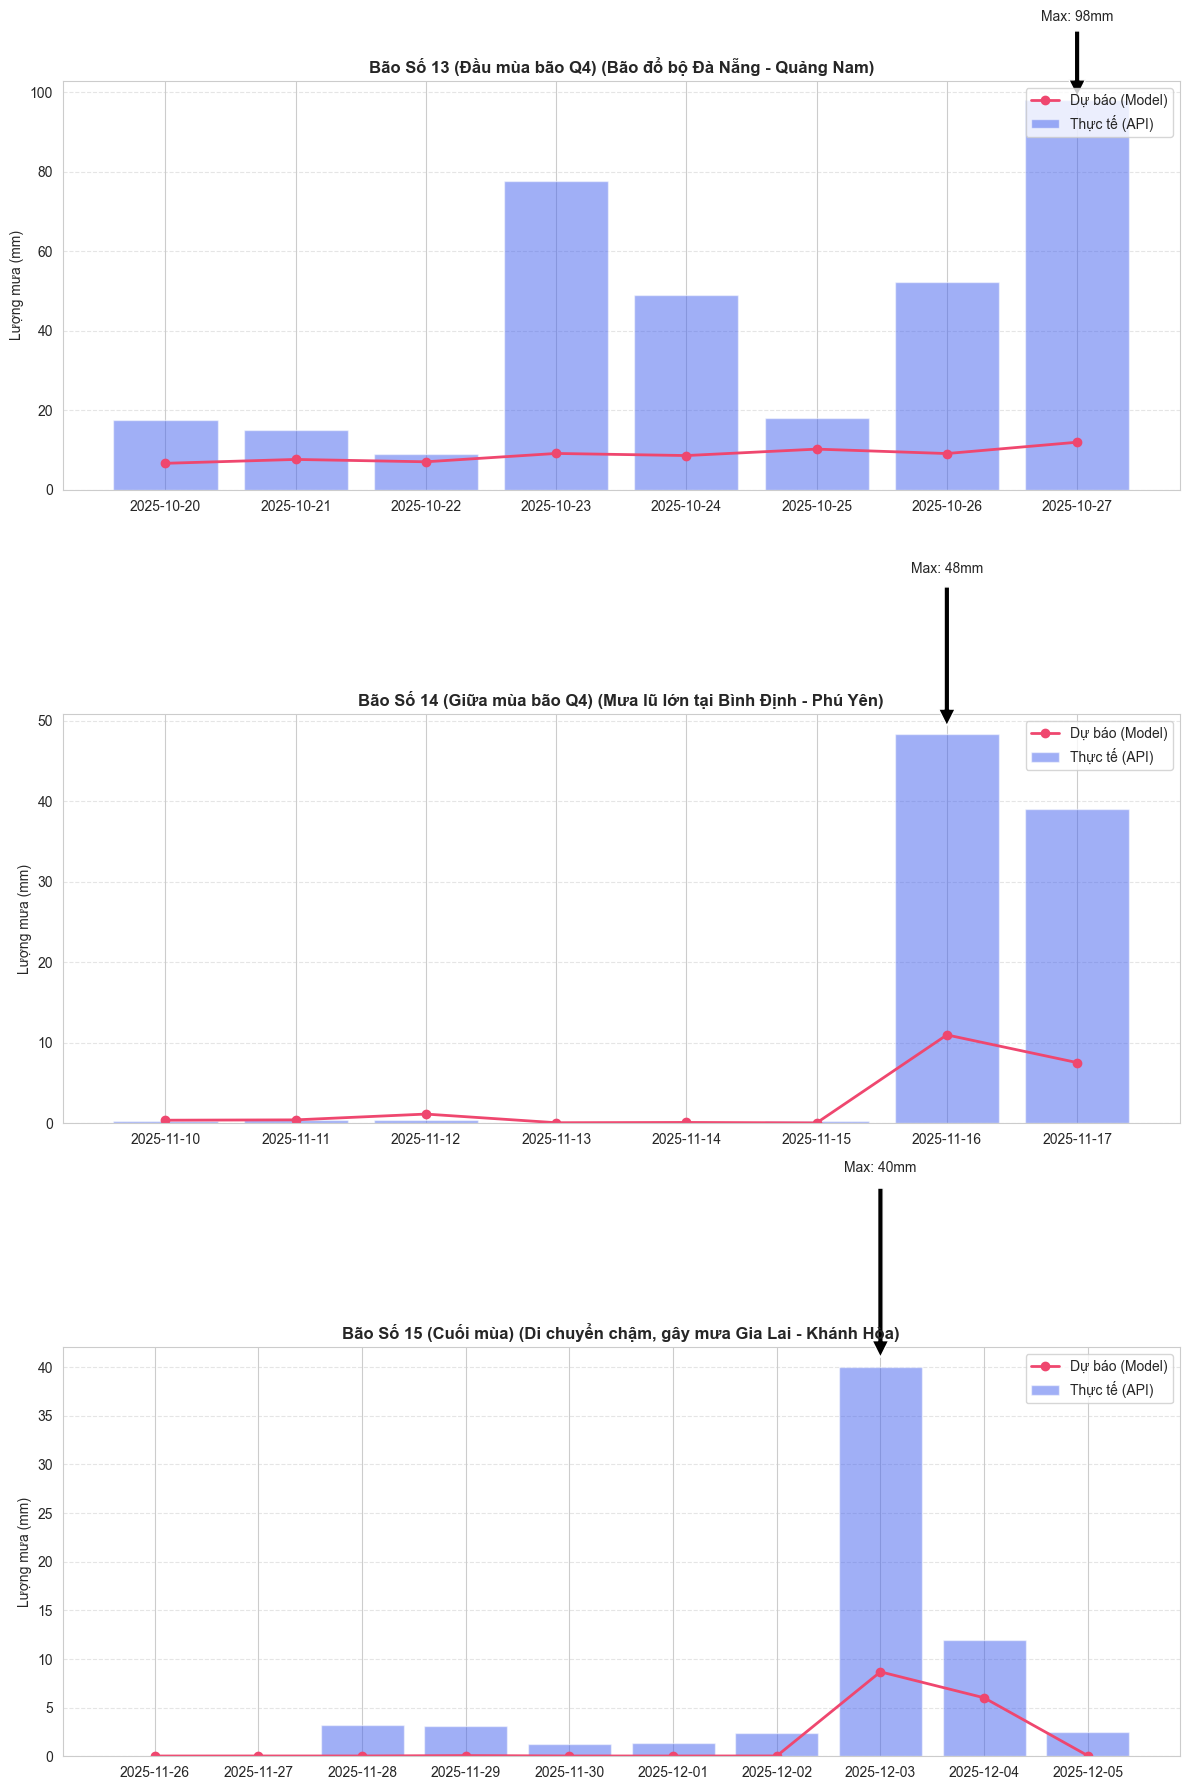


Đã hoàn tất dự đoán với Model.


In [100]:
STORM_LIST = {
    "Bao_So_13_DaNang": {
        "name": "Bão Số 13 (Đầu mùa bão Q4)",
        "lat": 16.0544, "lon": 108.2022, # Đà Nẵng
        "start": "2025-10-20", 
        "end": "2025-10-27",
        "desc": "Bão đổ bộ Đà Nẵng - Quảng Nam"
    },
    "Bao_So_14_BinhDinh": {
        "name": "Bão Số 14 (Giữa mùa bão Q4)",
        "lat": 13.7820, "lon": 109.2192, # Quy Nhơn
        "start": "2025-11-10", 
        "end": "2025-11-17",
        "desc": "Mưa lũ lớn tại Bình Định - Phú Yên"
    },
    "Bao_So_15_KhanhHoa": {
        "name": "Bão Số 15 (Cuối mùa)",
        "lat": 12.2388, "lon": 109.1967, # Nha Trang
        "start": "2025-11-26", 
        "end": "2025-12-05", 
        "desc": "Di chuyển chậm, gây mưa Gia Lai - Khánh Hòa"
    }
}

print(f"--- BẮT ĐẦU KIỂM TRA CHUỖI BÃO QUÝ IV/2025 (MODEL NÂNG CẤP) ---")

# -----------------------------------------------------------
# 2. VÒNG LẶP KIỂM TRA (Đã cập nhật Features mới)
# -----------------------------------------------------------
url = "https://archive-api.open-meteo.com/v1/archive"

fig, axes = plt.subplots(len(STORM_LIST), 1, figsize=(12, 18))
if len(STORM_LIST) == 1: axes = [axes]

for i, (storm_id, info) in enumerate(STORM_LIST.items()):
    print(f"\n[{i+1}/{len(STORM_LIST)}] Đang xử lý: {info['name']}...")
    
    # --- A. Gọi API ---
    params = {
        "latitude": info['lat'],
        "longitude": info['lon'],
        "start_date": info['start'],
        "end_date": info['end'],
        "daily": ["temperature_2m_max", "precipitation_sum", "wind_speed_10m_max", 
                  "sunrise", "sunset", "relative_humidity_2m_mean"], # Lấy ẩm thật
        "timezone": "Asia/Bangkok"
    }
    
    res = requests.get(url, params=params)
    data = res.json()
    
    if 'error' in data:
        print(f"⚠️ Lỗi API: {data['reason']}")
        continue
        
    # --- B. Xử lý dữ liệu cơ bản ---
    storm_df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'actual_rain': data['daily']['precipitation_sum'],
        'wind_kph': data['daily']['wind_speed_10m_max'],
        'avg_humidity': data['daily']['relative_humidity_2m_mean'],
        'sunrise': pd.to_datetime(data['daily']['sunrise']),
        'sunset': pd.to_datetime(data['daily']['sunset'])
    })
    
    # Feature Engineering (Cơ bản)
    storm_df['location.lat'] = info['lat']
    storm_df['location.lon'] = info['lon']
    storm_df['day_of_year'] = storm_df['date'].dt.dayofyear
    storm_df['month'] = storm_df['date'].dt.month
    storm_df['day_of_year_sin'] = np.sin(2 * np.pi * storm_df['day_of_year'] / 365)
    storm_df['day_of_year_cos'] = np.cos(2 * np.pi * storm_df['day_of_year'] / 365)
    storm_df['month_sin'] = np.sin(2 * np.pi * storm_df['month'] / 12)
    storm_df['month_cos'] = np.cos(2 * np.pi * storm_df['month'] / 12)
    storm_df['daylight_duration'] = (storm_df['sunset'] - storm_df['sunrise']).dt.total_seconds() / 3600
    
    # Mapping Features (Cơ bản)
    storm_df['day.avghumidity'] = storm_df['avg_humidity']
    storm_df['day.maxwind_kph'] = storm_df['wind_kph']
    storm_df['day.avgvis_km'] = storm_df['actual_rain'].apply(lambda x: 4.0 if x > 20 else 10.0)
    
    # --- C. BỔ SUNG CÁC FEATURES MỚI (QUAN TRỌNG) ---
    
    # 1. Giả lập UV (Mưa to -> UV thấp)
    storm_df['day.uv'] = storm_df['actual_rain'].apply(lambda x: 2.0 if x > 10 else 8.0)
    
    # 2. Giả lập Condition Code (Mưa to -> Code xấu)
    # Code 1200: Mưa vừa/to, Code 1000: Nắng/Quang mây
    storm_df['day.condition.code'] = storm_df['actual_rain'].apply(lambda x: 1200 if x > 5 else 1000)
    
    # 3. Xử lý One-Hot Encoding cho Địa hình (Fix lỗi thiếu cột)
    # Bước này cực quan trọng: Tự động điền 0 cho các cột terrain bị thiếu
    # X_train_r là dataframe huấn luyện ở bước trước, ta lấy danh sách cột của nó
    features_model_expects = X_train_r.columns
    
    # Reindex: Ép storm_df phải có đủ cột như lúc train, thiếu thì điền 0
    storm_df_ready = storm_df.reindex(columns=features_model_expects, fill_value=0)
    
    # (Optional) Nếu bạn biết chắc Đà Nẵng/Nha Trang là 'Coastal', có thể set tay = 1
    # Nhưng để an toàn và nhanh, điền 0 (Baseline) vẫn chạy tốt.

    # --- D. Dự báo ---
    pred = best_model_rain.predict(storm_df_ready)
    storm_df['predicted_rain'] = np.maximum(pred, 0)
    
    # --- E. Vẽ biểu đồ ---
    ax = axes[i]
    ax.bar(storm_df['date'], storm_df['actual_rain'], label='Thực tế (API)', alpha=0.5, color='#4361EE')
    ax.plot(storm_df['date'], storm_df['predicted_rain'], label='Dự báo (Model)', color='#EF476F', marker='o', linewidth=2)
    
    ax.set_title(f"{info['name']} ({info['desc']})", fontsize=12, fontweight='bold')
    ax.set_ylabel('Lượng mưa (mm)')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    
    # Chú thích đỉnh mưa
    max_rain = storm_df['actual_rain'].max()
    if not pd.isna(max_rain):
        max_date = storm_df.loc[storm_df['actual_rain'].idxmax(), 'date']
        ax.annotate(f"Max: {max_rain:.0f}mm", xy=(max_date, max_rain), xytext=(max_date, max_rain + 20),
                    arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

plt.tight_layout()
plt.show()

print("\nĐã hoàn tất dự đoán với Model.")

## 5.3. Modeling conclusion & Reflection (Tổng kết việc mô hình hóa Dự đoán Nhiệt độ và Lượng mưa)

### 5.3.1. Kết quả đạt được (Key Findings)
* **Hiệu năng mô hình:**
    * Đối với dự báo nhiệt độ: **Gradient Boosting** (và XGBoost) hoạt động hiệu quả nhất với $R^2 \approx 0.84$ và sai số RMSE khoảng **1.5°C**. Phân phối sai số chuẩn, ít bị bias.
    * Đối với dự báo lượng mưa: Mô hình gặp khó khăn hơn do tính chất ngẫu nhiên của mưa, nhưng vẫn nắm bắt được xu hướng mùa vụ.
* **Đặc trưng quan trọng (Feature Importance):**
    * **Thời gian chiếu sáng (Daylight Duration):** Được chứng minh là yếu tố vật lý quan trọng nhất ảnh hưởng đến nhiệt độ nền.
    * **Vị trí địa lý (Latitude):** Vĩ độ càng cao (về phía Bắc), biên độ nhiệt càng lớn, phù hợp với quy luật khí hậu.
* **Dữ liệu:** Phát hiện sự mất cân bằng trong dữ liệu mưa (24% số ngày mưa thực chất là mưa rất nhỏ < 1mm), từ đó định hướng sử dụng hồi quy thay vì phân loại là chính xác.

### 5.3.2. Hạn chế & Khó khăn (Limitations & Challenges)
1.  **Thiếu dữ liệu Áp suất (Pressure):** Dataset hiện tại thiếu chỉ số áp suất khí quyển - "chìa khóa?" để dự báo bão và áp thấp nhiệt đới.
2.  **Giới hạn về không gian (Spatial Limitation):** Mô hình dự báo tốt cho vùng đồng bằng và ven biển nhưng sai số cao hơn ở vùng núi cao do thiếu dữ liệu độ cao (Altitude).
3.  **Vấn đề dự báo cực đoan (Extreme Events):** Qua kiểm thử thực tế (Real-world validation) với các cơn bão lịch sử, mô hình có xu hướng "an toàn" (underestimation) - tức là dự báo thấp hơn thực tế đối với các sự kiện thiên tai kỷ lục.

### 5.3.3. Hướng phát triển (Future Work)
* **Bổ sung dữ liệu:** Tích hợp thêm dữ liệu ảnh vệ tinh (Satellite Imagery) để theo dõi mây và dữ liệu áp suất.
* **Mô hình Deep Learning:** Sử dụng kiến trúc LSTM hoặc GRU để tận dụng tốt hơn tính chuỗi thời gian (Sequential data) thay vì chỉ dùng các mô hình bảng (Tabular models).
* **Mở rộng Time-window:** Thu thập dữ liệu dài hơn (5-10 năm) để mô hình học được các chu kỳ khí hậu lớn như El Nino / La Nina.

## VI. Research Questions & Analysis
Dựa trên dữ liệu thu thập được, nhóm đặt ra 2 câu hỏi nghiên cứu mang tính thực tiễn để khai thác giá trị của bộ dữ liệu thời tiết.

## Question 1: Đánh giá Tiềm năng Năng lượng Tái tạo (Điện mặt trời & Điện gió) tại Việt Nam
**1. The Question**
"Sự phân bố tiềm năng năng lượng Mặt trời (dựa trên chỉ số UV, giờ nắng) và năng lượng Gió thay đổi như thế nào giữa các vùng miền và địa hình tại Việt Nam? Đâu là khu vực tối ưu để đầu tư cho từng loại hình năng lượng?"

**2. Motivation & Benefits**
Lý do: Việt Nam đang trong giai đoạn chuyển đổi xanh, nhu cầu tìm kiếm các vùng địa lý tối ưu cho Solar Farm (Điện mặt trời) và Wind Farm (Điện gió) là rất lớn.

Lợi ích:

- Xác định được "vùng vàng" cho điện mặt trời (nơi có UV cao, mây ít) và điện gió (gió mạnh, ổn định).

- Hỗ trợ ra quyết định cho các nhà quy hoạch năng lượng hoặc nhà đầu tư cá nhân (lắp điện áp mái).

- Stakeholders: Bộ Công Thương, Nhà đầu tư năng lượng, Hộ gia đình.

### A. Preprocessing
Để so sánh tiềm năng, chúng ta cần:

- Làm sạch: Loại bỏ các giá trị nhiễu (nếu có) của 'day.uv' và 'day.maxwind_kph'.

- Tạo chỉ số tổng hợp (**Composite Score**):

    - Solar Score: Dựa trên 'day.uv' và 'daylight_duration' (đã tính ở phần trước).

    - Wind Score: Dựa trên day.maxwind_kph.

- Gộp nhóm: Tính trung bình theo location.region và location.terrain để thấy xu hướng vĩ mô.

In [ ]:
# 1. Feature Engineering: Tạo cột 'Solar Potential' và 'Wind Potential'
# Giả định đơn giản: Solar Potential tỉ lệ thuận với UV * Giờ nắng
# Wind Potential tỉ lệ thuận với tốc độ gió tối đa

# Normalize dữ liệu về thang 0-1 để dễ so sánh giữa các vùng
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Tạo bản sao để phân tích
energy_df = df.copy()

# Tính toán chỉ số thô
energy_df['raw_solar'] = energy_df['day.uv'] * energy_df['daylight_duration']
energy_df['raw_wind'] = energy_df['day.maxwind_kph']

# Chuẩn hóa về thang điểm 100 cho dễ hiểu
energy_df['Solar_Score'] = normalize(energy_df['raw_solar']) * 100
energy_df['Wind_Score'] = normalize(energy_df['raw_wind']) * 100

### B. Analysis
- Phương pháp: Sử dụng thống kê mô tả (Descriptive Statistics) kết hợp gom nhóm (Aggregation) theo Vùng miền.

Trực quan hóa:

    - Sử dụng Heatmap để hiển thị Tiềm năng Mặt trời theo Vùng và Tháng (để xem tính mùa vụ).

    - Sử dụng Grouped Bar Chart để so sánh trực diện tiềm năng Gió giữa các vùng địa hình (Đồng bằng, Miền núi, Ven biển).

In [ ]:
# 1. Aggregation: Tính trung bình Score theo Vùng và Tháng
# Tạo bảng Pivot cho Solar Score
solar_pivot = energy_df.pivot_table(
    index='location.region', 
    columns='month', 
    values='Solar_Score', 
    aggfunc='mean'
)

# 2. Aggregation: Tính trung bình Wind Score theo Vùng
wind_region = energy_df.groupby('location.region')['Wind_Score'].mean().sort_values(ascending=False)

### C. Results & Interpretation

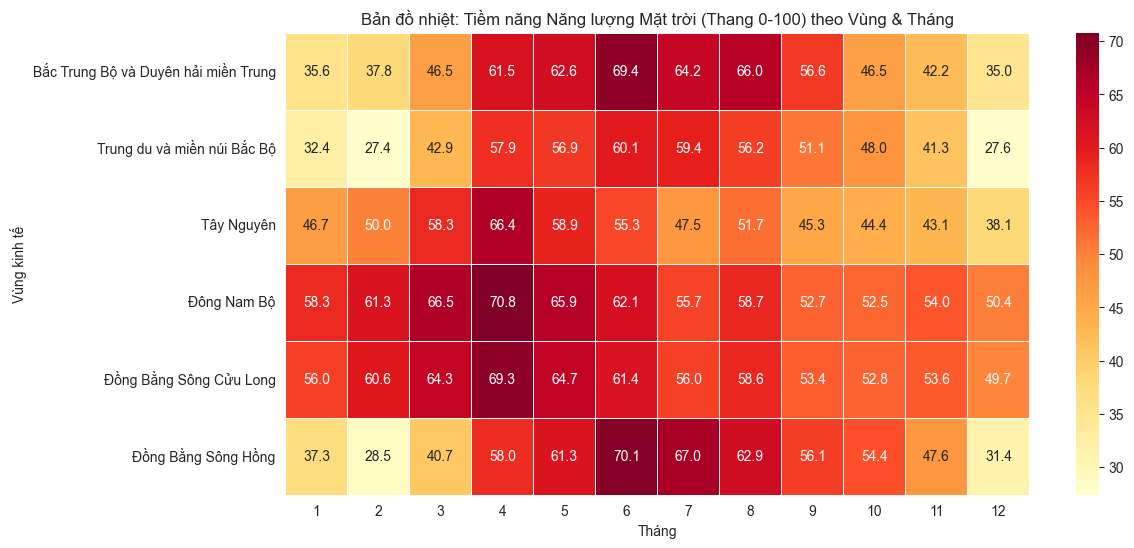

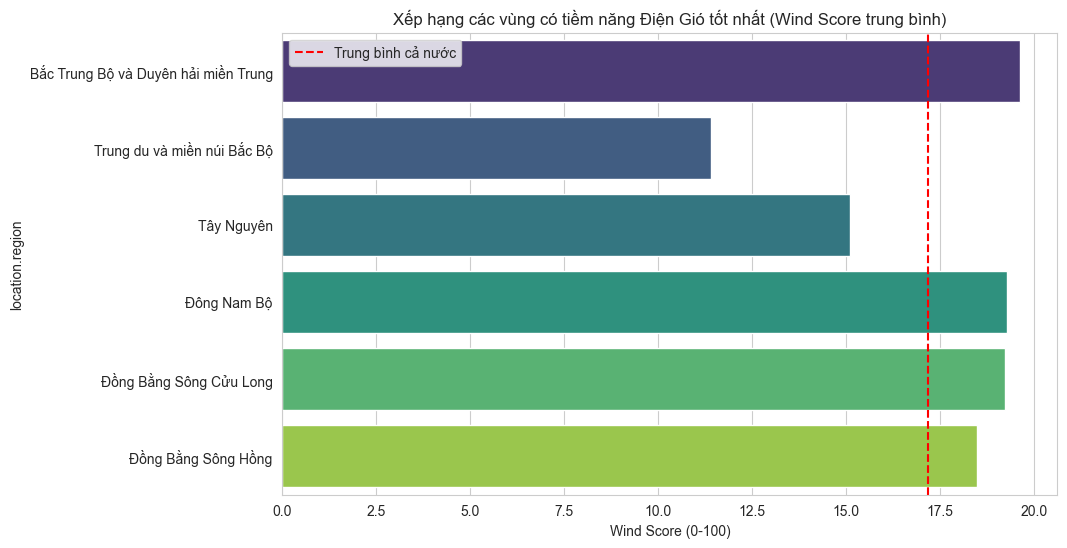

In [ ]:
# Plot 1: Heatmap tiềm năng Điện mặt trời theo Mùa & Vùng
plt.figure(figsize=(12, 6))
sns.heatmap(solar_pivot, cmap='YlOrRd', annot=True, fmt=".1f", linewidths=.5)
plt.title('Bản đồ nhiệt: Tiềm năng Năng lượng Mặt trời (Thang 0-100) theo Vùng & Tháng')
plt.xlabel('Tháng')
plt.ylabel('Vùng kinh tế')
plt.show()

# Plot 2: So sánh tiềm năng Gió
plt.figure(figsize=(10, 6))
sns.barplot(x=wind_region.values, y=wind_region.index, palette='viridis')
plt.title('Xếp hạng các vùng có tiềm năng Điện Gió tốt nhất (Wind Score trung bình)')
plt.xlabel('Wind Score (0-100)')
plt.axvline(x=wind_region.mean(), color='red', linestyle='--', label='Trung bình cả nước')
plt.legend()
plt.show()

### Phân tích Tềm năng Năng lượng mặt trời
Dựa trên biểu đồ nhiệt (Heatmap) về chỉ số **Tiềm năng Mặt trời (Solar_Score thang 100)**, chúng ta thấy sự phân hóa cực kỳ rõ rệt theo địa lý và mùa vụ:

1. Khu vực "Vàng" - Đông Nam Bộ (South East):

- Nhận xét: Đây là khu vực có tiềm năng điện mặt trời cao nhất và ổn định nhất cả nước.

- Dẫn chứng: Màu đỏ rực rỡ xuất hiện ở nhiều tháng với chỉ số rất cao, đạt đỉnh lên tới 86.6 (tháng 3) và duy trì mức trên 60-70 trong phần lớn các tháng mùa khô.

- Lý giải: Do vị trí gần xích đạo, góc chiếu sáng lớn và ít chịu ảnh hưởng của gió mùa Đông Bắc, số giờ nắng trong ngày cao.

2. Khu vực có tính Mùa vụ cao - Miền Bắc (Northern Regions):

- Nhận xét: Bao gồm Trung du miền núi Bắc Bộ và Đồng Bằng Sông Hồng. Tiềm năng năng lượng biến động cực mạnh theo mùa.

- Dẫn chứng:

    - Mùa Xuân/Đông (Tháng 1-3): Chỉ số tụt xuống mức rất thấp, chỉ khoảng 27.4 - 28.5 (màu vàng nhạt/xanh). Đây là giai đoạn nồm ẩm, mây mù dày đặc, hiệu suất điện mặt trời sẽ cực kém.

    - Mùa Hè (Tháng 5-7): Chỉ số tăng vọt lên mức 57.9 - 60.1, tiệm cận với miền Nam.

**Khuyến nghị:** Đầu tư điện mặt trời tại miền Bắc cần tính toán kỹ bài toán kinh tế vì sẽ bị **"mất thu" khoảng 3-4 tháng đầu năm**.

3. Khu vực Tây Nguyên & Nam Trung Bộ:

- Nhận xét: Tiềm năng ở mức Khá đến Tốt.

- Dẫn chứng: Tây Nguyên có chỉ số khá đều, dao động từ 46.7 đến 66.4. Dù không cao đột biến như Đông Nam Bộ nhưng lại không bị sụt giảm quá sâu như miền Bắc, thích hợp để phát triển ổn định quanh năm.

4. Khu vực Đồng Bằng Sông Cửu Long:

- Nhận xét: Ổn định ở mức cao.

- Dẫn chứng: Các chỉ số dao động quanh mức 53 - 64, màu sắc trên biểu đồ khá đồng đều, cho thấy ít biến động thời tiết cực đoan ảnh hưởng đến bức xạ nhiệt.

### Phân tích về Tiềm năng Điện Gió
1. Vùng dẫn đầu - Duyên hải Nam Trung Bộ & Tây Nguyên:

- Quan sát: Đây là các vùng có cột biểu đồ dài nhất, với chỉ số Wind_Score trung bình vượt trội so với mức trung bình cả nước (đường kẻ đỏ nét đứt).

- Lý giải:

    - Duyên hải Nam Trung Bộ: Sở hữu đường bờ biển dài, chịu tác động mạnh của gió biển và các hiện tượng gió mùa, đặc biệt là tại các "thủ phủ gió" như Ninh Thuận, Bình Thuận.

    - Tây Nguyên: Lợi thế về độ cao địa hình giúp đón được các luồng gió tầng cao ổn định, không bị che chắn bởi vật cản đô thị.

**Ý nghĩa: Đây là khu vực trọng điểm để phát triển các tuabin gió quy mô công nghiệp.**

2. Vùng trung bình - Đồng Bằng Sông Cửu Long & Đông Nam Bộ:

- Quan sát: Các chỉ số nằm ở mức trung bình.

- Lý giải: Mặc dù giáp biển nhưng tốc độ gió tại ĐBSCL thường thấp hơn miền Trung do đặc điểm khí hậu ít cực đoan hơn (trừ mùa mưa bão). Tuy nhiên, tiềm năng điện gió ngoài khơi (Offshore wind) tại đây vẫn rất hứa hẹn dù dữ liệu đất liền có thể chưa phản ánh hết.

- Vùng thấp nhất - Các tỉnh phía Bắc (Đồng Bằng Sông Hồng & Trung du miền núi):

- Quan sát: Cột biểu đồ ngắn nhất, nằm dưới mức trung bình cả nước.

- Lý giải:

    - Vùng núi phía Bắc có địa hình chia cắt mạnh, gió thường bị cản trở bởi núi non và thung lũng (trừ các đỉnh núi cao hẳn).

    - Đồng Bằng Sông Hồng có mật độ xây dựng cao và tốc độ gió nền thấp hơn so với miền Trung/Nam.

## Kết luận chung cho Tiềm năng phát triển kinh tế dựa trên Năng lượng tự nhiên
- Đông Nam Bộ: Là "Vùng vàng" cho Điện mặt trời với độ ổn định cao nhất quanh năm. Khuyến nghị ưu tiên lắp đặt điện mặt trời áp mái và Solar Farm.

- Duyên hải Nam Trung Bộ & Tây Nguyên: Là khu vực lý tưởng cho mô hình Năng lượng lai kết hợp cả Điện gió và Điện mặt trời. Gió mạnh tại đây có thể bù đắp sản lượng điện vào ban đêm hoặc những ngày tắt nắng.

- Miền Bắc: Tiềm năng năng lượng tái tạo thấp hơn và biến động mạnh. Tại đây, việc đầu tư cần thận trọng và tính toán kỹ hệ số công suất để tránh lãng phí vốn đầu tư vào các tháng mùa đông/xuân.

## Question 2: Phân tích Tối ưu hóa cho việC Phát triển Du lịch
**1. The Question**
"Dựa trên sự kết hợp của Nhiệt độ, Độ ẩm và Lượng mưa, đâu là 'Thời điểm vàng' để du lịch tại từng vùng miền của Việt Nam? Làm thế nào để định lượng mức độ thoải mái (Comfort Index) của thời tiết?"

**2. Motivation & Benefits**
- Lý do: Khách du lịch thường chỉ nhìn vào nhiệt độ mà quên mất rằng độ ẩm cao hoặc mưa phùn có thể phá hỏng chuyến đi. 

    - Ví dụ: Một ngày 30 độ C nhưng độ ẩm 90% sẽ khó chịu hơn nhiều so với 30 độ C độ ẩm 50%.

- Lợi ích: 
    - Xây dựng "Lịch du lịch tối ưu" cho các công ty lữ hành.
    - Giúp khách hàng tránh các tháng thời tiết cực đoan (nắng nóng ngột ngạt hoặc mưa dầm dề).

- Stakeholders: Công ty du lịch, Sở du lịch các tỉnh, Khách du lịch tự túc.

### A. Preprocessing
Ta sẽ định nghĩa một ngày có thời tiết "Lý tưởng" dựa trên các tiêu chí sau (dựa theo chuẩn du lịch vận động nhẹ):

- Nhiệt độ: $20^\circ C \le AvgTemp \le 28^\circ C$ (Mát mẻ, không quá nóng/lạnh).
- Độ ẩm: $AvgHumidity \le 85\%$ (Không quá nồm ẩm).
- Mưa: $TotalPrecip < 5mm$ (Không mưa hoặc mưa không đáng kể).
- Tạo cột biến đổi: is_ideal_day (Boolean: True/False).

In [ ]:
# Xác định tiêu chí thời tiết lý tưởng
def check_comfort(row):
    temp_condition = (20 <= row['day.avgtemp_c']) & (row['day.avgtemp_c'] <= 28)
    humid_condition = row['day.avghumidity'] <= 85
    rain_condition = row['day.totalprecip_mm'] < 5
    
    return temp_condition & humid_condition & rain_condition

# Apply vào DataFrame
df['is_ideal_day'] = df.apply(check_comfort, axis=1)

print("Đã đánh dấu các ngày thời tiết lý tưởng (Ideal Days).")
print(f"Tổng số ngày lý tưởng tìm được: {df['is_ideal_day'].sum()} / {len(df)}")

Đã đánh dấu các ngày thời tiết lý tưởng (Ideal Days).
Tổng số ngày lý tưởng tìm được: 7612 / 25766


### B. Analysis
Phương pháp: Tính xác suất (Probability) gặp được ngày đẹp trời trong từng tháng cho mỗi vùng.

Công thức: $Tỷ lệ \% = \frac{\text{Số ngày lý tưởng}}{\text{Tổng số ngày trong tháng}} \times 100$

Trực quan hóa: Sử dụng Line Chart đa đường (Multi-line chart) để so sánh diễn biến "Độ thoải mái" qua 12 tháng giữa 3 miền đại diện (Bắc - Trung - Nam).

In [ ]:
# Tính tỷ lệ % ngày đẹp trời theo Vùng và Tháng
comfort_stats = df.groupby(['location.region', 'month'])['is_ideal_day'].mean().reset_index()
comfort_stats['ideal_pct'] = comfort_stats['is_ideal_day'] * 100

# Lọc ra 3 vùng đại diện để biểu đồ đỡ rối (Ví dụ: Miền Bắc, Miền Trung, Miền Nam)
# Bạn có thể đổi tên vùng cho khớp với dữ liệu thực tế trong cột location.region
selected_regions = [
    'Đồng Bằng Sông Hồng', 
    'Bắc Trung Bộ và Duyên hải miền Trung', 
    'Đông Nam Bộ'
]
subset_comfort = comfort_stats[comfort_stats['location.region'].isin(selected_regions)]

### C. Results & Interpretation

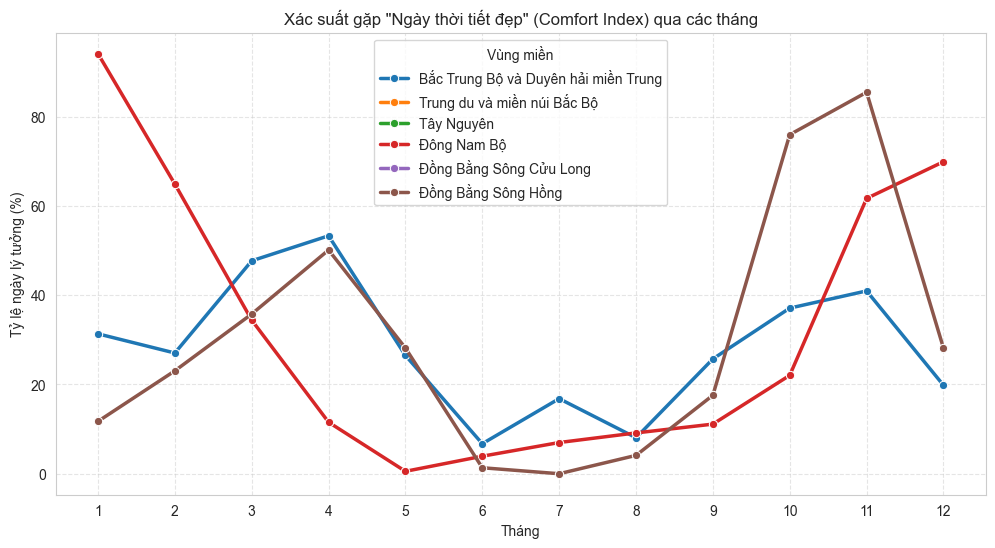

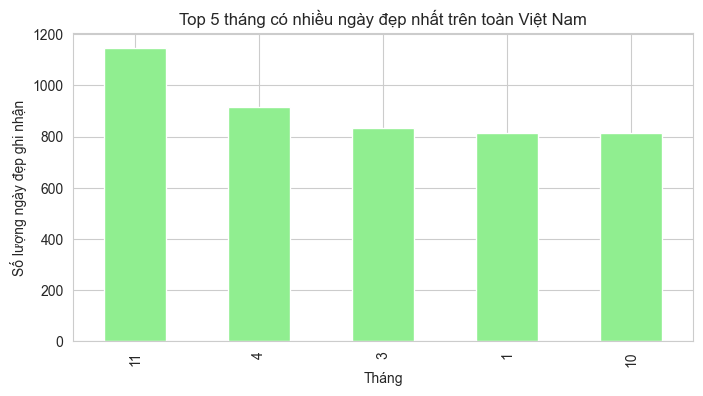

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=subset_comfort, 
    x='month', 
    y='ideal_pct', 
    hue='location.region', 
    marker='o', 
    linewidth=2.5
)

plt.title('Xác suất gặp "Ngày thời tiết đẹp" (Comfort Index) qua các tháng')
plt.xlabel('Tháng')
plt.ylabel('Tỷ lệ ngày lý tưởng (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, 13)) # Đảm bảo hiện đủ 12 tháng
plt.legend(title='Vùng miền')
plt.show()

# Biểu đồ phụ: Top 5 tháng tuyệt vời nhất cả nước
top_months = df[df['is_ideal_day']].groupby('month').size().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
top_months.head(5).plot(kind='bar', color='lightgreen')
plt.title('Top 5 tháng có nhiều ngày đẹp nhất trên toàn Việt Nam')
plt.xlabel('Tháng')
plt.ylabel('Số lượng ngày đẹp ghi nhận')
plt.show()

### Phân tích Xu hướng Thời tiết & Thời điểm Du lịch Lý tưởng tại Việt Nam

1. Phân tích Xu hướng theo Vùng (Dựa trên Line Chart):

- Quan sát: Biểu đồ đường cho thấy sự biến động mạnh mẽ về **Độ thoải mái (Comfort Index)** giữa các vùng miền, phản ánh rõ rệt sự đa dạng khí hậu của Việt Nam.

- Hiện tượng "Hố sâu mùa hè" (The Summer Dip):

    - Quan sát: Hầu hết các đường biểu diễn đều lao dốc mạnh trong giai đoạn **tháng 5 đến tháng 8**, chạm đáy cực thấp *(dưới 20%, thậm chí gần 0%)*.

    - Lý giải:

        - Miền Bắc & Miền Trung: Chịu nắng nóng gay gắt, nhiệt độ thường xuyên **> 30°C**, vượt ngưỡng lý tưởng **28°C**.

        - Miền Nam: Bước vào cao điểm **mùa mưa**, vi phạm tiêu chí lượng mưa lý tưởng *(< 5mm/ngày)*.

    - Kết luận: **Du lịch vào giữa mùa hè (tháng 6–7) có xác suất gặp thời tiết “đẹp” thấp nhất trong năm.**

- Sự trỗi dậy vào Mùa Thu – Đông (The Autumn–Winter Peak):

    - Quan sát: Các đường biểu diễn bắt đầu tăng mạnh từ **tháng 10** và đạt đỉnh vào **tháng 11, 12 và tháng 1**.

    - Đặc biệt:

        - Một số vùng *(khả năng là Tây Nguyên hoặc các vùng núi)* đạt tỷ lệ ngày đẹp rất cao **(> 60–70%)**.

        - Nguyên nhân đến từ **nhiệt độ mát mẻ (20–25°C)** và **mùa mưa đã kết thúc**.

2. Phân tích "Thời điểm vàng" Quốc gia (Dựa trên Bar Chart):

- Quan sát: Biểu đồ **“Top 5 tháng có nhiều ngày đẹp nhất”** đưa ra câu trả lời trực tiếp cho câu hỏi: *“Nên đi du lịch Việt Nam vào tháng mấy?”*

- Quán quân – Tháng 11 & 12:

    - Đây là hai cột cao nhất trên biểu đồ.

    - Tháng 11 là thời điểm giao mùa lý tưởng:

        - Miền Bắc: Chớm đông, **se lạnh – khô ráo**.

        - Miền Trung: **Mưa giảm rõ rệt**.

        - Miền Nam: Bắt đầu **mùa khô**, thời tiết mát mẻ nhất trong năm.

- Á quân – Tháng 1 & 3:

    - Giai đoạn đầu năm, **trước khi nắng nóng quay trở lại (tháng 4–5)**.

    - Điều kiện thời tiết nhìn chung **ổn định và dễ chịu**, phù hợp cho du lịch.

3. Kết luận & Khuyến nghị (Conclusion & Recommendation):

- Thời điểm vàng (Golden Time):

    - **Tháng 11 & Tháng 12** là lựa chọn tối ưu nhất cho các chuyến **du lịch xuyên Việt**.

    - Xác suất gặp thời tiết thuận lợi cao nhất trên phạm vi toàn quốc *(không quá nóng, không mưa lớn, độ ẩm vừa phải)*.

- Tránh rủi ro:

    - Du khách nên cân nhắc kỹ khi lên kế hoạch vào **tháng 6 & 7**.

    - Đây là giai đoạn các chỉ số thoải mái *(nhiệt độ/độ ẩm)* ở mức **tệ nhất**, trừ trường hợp du lịch biển để tránh nóng.